## Final Project Submission

Please fill out:
* Student name: Amanda Gaeta
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: Lindsey Berlin
* Blog post URL:

## Introduction

Microsoft wants to start their own movie production studio, but they do not have the movie knowledge that they need to start. This workbook walks through the data analysis used to provide movie landscape knowledge, movie production recommendations, and possible next steps of analysis.

The below uses IMDB and The Numbers data on movies from the 2010s (2010-2019) to answer the following:
- Question 1: What were the top movie genres made in the 2010s?
- Question 2: What is the best month to release a movie for highest worldwide gross?
- Question 3: Of movies that breakeven (ROI >= 1), what genres are most represented?
- Question 4: Based on production budget and average ratings, what genres are the best investments?
- Question 5: For these breakeven movies that fall into these genres, what is the recommended runtime and who are the highest rated directors?

In [1]:
#import packages for file import, cleansing and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style(style="whitegrid")

## Data Source Decisions

Data sources available included:
- IMDB (Internet movie database) - information related to films, television programs, home videos, video games, and streaming content online
- Box Office Mojo - tracks box office revenue
- Rotten Tomatoes – movie reviews from critics and everyday watchers alike, freshness scoe
- The Numbers – box office data

IMDB was selected because it was the largest data set with greatest breadth of data. This breadth came in multiple files (in the rawData folder) and was easy to match as all movies have unique ids for most accurate merging. Part of these IMDB files was one specifically on ratings, which made Rotten Tomatoes unecessary especially with less specific ways of matching due to different ids than IMDB. Finally, both The Numbers and Box Office Mojo focus on box office data, but Numbers had more data on more movies including budgets versus gross. Box Office Mojo only provided gross.


## Import, join and merge relevant data tables

Start with IMDB files including Title Basics and Title Ratings.

In [2]:
# Import Title Basics
imdb_tb_df = pd.read_csv('rawData/zippedData/imdb.title.basics.csv.gz')
imdb_tb_df.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [3]:
# Import Title Ratings
imdb_tr_df = pd.read_csv('rawData/zippedData/imdb.title.ratings.csv.gz')
imdb_tr_df.head()

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [4]:
# They are from the same source and have the 'tconst' id to use as a joining reference
# Merging versus joining because ratings is required for the bulk of the analysis
imdb_tb_tr = imdb_tb_df.merge(imdb_tr_df, on='tconst')

In [5]:
# Check new table, still more than enough data for analysis with 73k
imdb_tb_tr.info()
# Runtime_minutes has many nulls, be aware in further analysis

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 5.1+ MB


In [6]:
# I see genres has some missing values, fill with Unknown for now
imdb_tb_tr['genres'] = imdb_tb_tr['genres'].fillna('Unknown')

In [7]:
# Preview runtime_minutes values to fill nulls
imdb_tb_tr['runtime_minutes']

0        175.0
1        114.0
2        122.0
3          NaN
4         80.0
         ...  
73851     75.0
73852     98.0
73853      NaN
73854      NaN
73855     72.0
Name: runtime_minutes, Length: 73856, dtype: float64

In [8]:
# Fill nulls with 0.0. If doing runtime_mins analysis can easily make table that excludes these
imdb_tb_tr['runtime_minutes'] = imdb_tb_tr['runtime_minutes'].fillna(0.0)

In [9]:
# Check edited table info, nulls populated
imdb_tb_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  73856 non-null  float64
 5   genres           73856 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 5.1+ MB


We are also interested in writer and director analysis for our last question, so import and join IMDB Title Crew to new dataset from above

In [10]:
# Import IMDB Title Crew file
imdb_tc_df = pd.read_csv('rawData/zippedData/imdb.title.crew.csv.gz')
# Preview file
imdb_tc_df.head()

,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,NaN,"nm0175726,nm1802864"
2,tt0462036,nm1940585,nm1940585
3,tt0835418,nm0151540,"nm0310087,nm0841532"
4,tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943


In [11]:
# Use join as writers and directors will be nice to have
imdb_tb_tr_tc = imdb_tb_tr.set_index('tconst').join(imdb_tc_df.set_index('tconst'))

In [12]:
# Check info on new table to confirm join, good rate of matches especially at director level
imdb_tb_tr_tc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73856 entries, tt0063540 to tt9916160
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   primary_title    73856 non-null  object 
 1   original_title   73856 non-null  object 
 2   start_year       73856 non-null  int64  
 3   runtime_minutes  73856 non-null  float64
 4   genres           73856 non-null  object 
 5   averagerating    73856 non-null  float64
 6   numvotes         73856 non-null  int64  
 7   directors        73104 non-null  object 
 8   writers          63295 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 8.1+ MB


In [13]:
# Post join reset the index
imdb_tb_tr_tc = imdb_tb_tr_tc.reset_index()

In [14]:
# Parse out genres into boolean columns for analysis
imdb_tb_tr_tc['genres']

0          Action,Crime,Drama
1             Biography,Drama
2                       Drama
3                Comedy,Drama
4        Comedy,Drama,Fantasy
                 ...         
73851             Documentary
73852            Drama,Family
73853             Documentary
73854                 Unknown
73855             Documentary
Name: genres, Length: 73856, dtype: object

In [15]:
# Check type
type(imdb_tb_tr_tc['genres'][0])

str

In [16]:
# Currently strings, need to convert to lists
imdb_tb_tr_tc['genres'] = imdb_tb_tr_tc['genres'].str.split(',')

In [17]:
# Establish variable for Series
imdb_genres = imdb_tb_tr_tc['genres']

In [18]:
#Establish empyt list to collect all possible genres. These will be made into columns
imdb_genres_list = []

# Start with rows in index
for row in imdb_genres.index:
    # Access the list data type in each row, it will change with every row in the index
    for item in imdb_genres[row]:
        # append the genre that is taken as an item from the list within the row and add it to the genres_list
        imdb_genres_list.append(item) 

# Define a set of the genres_list from the above for loop; reassign the genres_list variable name to this set
imdb_genres_list = set(imdb_genres_list)

In [19]:
# Check list
imdb_genres_list

{'Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'Unknown',
 'War',
 'Western'}

In [20]:
# Define a new DataFrame for genres to add Boolean columns to
imdb_genres = pd.DataFrame(imdb_tb_tr_tc['genres'])

In [21]:
# Preview new DataFrame
imdb_genres

,genres
0,"[Action, Crime, Drama]"
1,"[Biography, Drama]"
2,[Drama]
3,"[Comedy, Drama]"
4,"[Comedy, Drama, Fantasy]"
...,...
73851,[Documentary]
73852,"[Drama, Family]"
73853,[Documentary]
73854,[Unknown]


In [22]:
# Use for loop to create columns for each genre in the deduplicated set of genres for the genres_list
for genre in imdb_genres_list:
    #create a new column in our new DataFrame
    imdb_genres[genre] = 0

In [23]:
# View DataFrame. Each genre now has its own column
imdb_genres

,genres,Music,War,Reality-TV,Sport,Drama,Adventure,Game-Show,Animation,History,...,Horror,Crime,Family,Unknown,Thriller,Western,Action,Short,Sci-Fi,Biography
0,"[Action, Crime, Drama]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[Biography, Drama]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[Drama],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[Comedy, Drama]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[Comedy, Drama, Fantasy]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73851,[Documentary],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73852,"[Drama, Family]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73853,[Documentary],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73854,[Unknown],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
for row in imdb_genres.index:
    # Using previous for loop, edit it to access our new DF's column 'genres' THEN the row
    # This will get us to the list of genres in the given row
    for item in imdb_genres['genres'][row]:
        # Then say access the column that matches single genre in that list of genres (item) in that row (row)
        imdb_genres[item][row] = 1

<ipython-input-24-e66ac367fcb4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_genres[item][row] = 1


In [25]:
# Review table and check work
imdb_genres

,genres,Music,War,Reality-TV,Sport,Drama,Adventure,Game-Show,Animation,History,...,Horror,Crime,Family,Unknown,Thriller,Western,Action,Short,Sci-Fi,Biography
0,"[Action, Crime, Drama]",0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,"[Biography, Drama]",0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,[Drama],0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[Comedy, Drama]",0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[Comedy, Drama, Fantasy]",0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73851,[Documentary],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73852,"[Drama, Family]",0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
73853,[Documentary],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73854,[Unknown],0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Merge previous IMDB dataset with new genres table

In [26]:
# Same DataFrame length, merge on indices
imdb_with_genre_cols = imdb_tb_tr_tc.merge(imdb_genres, left_index=True, right_index=True)

In [27]:
# Check new table
imdb_with_genre_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  73856 non-null  float64
 5   genres_x         73856 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
 8   directors        73104 non-null  object 
 9   writers          63295 non-null  object 
 10  genres_y         73856 non-null  object 
 11  Music            73856 non-null  int64  
 12  War              73856 non-null  int64  
 13  Reality-TV       73856 non-null  int64  
 14  Sport            73856 non-null  int64  
 15  Drama            73856 non-null  int64  
 16  Adventure        73856 non-null  int64  
 17  Game-Show   

## Additionally we need financial data where relevant for ROI analysis

Prep The Numbers gross data for merge with IMDB. It has more records than Rotten Tomatoes data and ability to get budget vesus gross for ROI calculation.

Cleaning includes: converting gross data to millions, calculating domestic and foreign gross in mill and percentages, and calculating production ROI

In [28]:
#import file tn.movie_budgets.csv.gz
tn_mb_df = pd.read_csv('rawData/zippedData/tn.movie_budgets.csv.gz')
tn_mb_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [29]:
# Since no way to match via ID, create DIY unique ID via title and year to match on for future join
# First do it for main table that will be joined with imdb_with_genre_cols 
imdb_with_genre_cols['title_year'] = imdb_with_genre_cols['primary_title'] + ' ' + imdb_with_genre_cols['start_year'].astype(str)

In [30]:
# The Numbers table doesn't have year, so will need to parse out year from release_date; test first
tn_mb_df['release_date'][0].split(", ")[1]

'2009'

In [31]:
tn_mb_df['release_year'] = tn_mb_df['release_date'].map(lambda x: x.split(", ")[1])

In [32]:
# Check work
tn_mb_df['release_year']

0       2009
1       2011
2       2019
3       2015
4       2017
        ... 
5777    2018
5778    1999
5779    2005
5780    2015
5781    2005
Name: release_year, Length: 5782, dtype: object

In [33]:
# Now can create title and year ID in The Numbers file
tn_mb_df['title_year'] = tn_mb_df['movie'] + ' ' + tn_mb_df['release_year'].astype(str)

In [34]:
# Check work
tn_mb_df['title_year']

0                                            Avatar 2009
1       Pirates of the Caribbean: On Stranger Tides 2011
2                                      Dark Phoenix 2019
3                           Avengers: Age of Ultron 2015
4                 Star Wars Ep. VIII: The Last Jedi 2017
                              ...                       
5777                                         Red 11 2018
5778                                      Following 1999
5779                  Return to the Land of Wonders 2005
5780                           A Plague So Pleasant 2015
5781                              My Date With Drew 2005
Name: title_year, Length: 5782, dtype: object

In [35]:
# Review The Numbers table info
tn_mb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
 6   release_year       5782 non-null   object
 7   title_year         5782 non-null   object
dtypes: int64(1), object(7)
memory usage: 361.5+ KB


In [36]:
# Convert worldwide_gross to float
tn_mb_df['worldwide_gross'] = tn_mb_df['worldwide_gross'].str.replace(',','')
tn_mb_df['worldwide_gross'] = tn_mb_df['worldwide_gross'].str.replace('$','').astype(float)

In [37]:
# Create column that converts worldwide_gross to millions
tn_mb_df['worldwide_gross_in_mil'] = round((tn_mb_df['worldwide_gross']/1000000),2)

In [38]:
# Check work
tn_mb_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,title_year,worldwide_gross_in_mil
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625",2.776345e+09,2009,Avatar 2009,2776.35
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875",1.045664e+09,2011,Pirates of the Caribbean: On Stranger Tides 2011,1045.66
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350",1.497624e+08,2019,Dark Phoenix 2019,149.76
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868",1.403014e+09,2015,Avengers: Age of Ultron 2015,1403.01
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382",1.316722e+09,2017,Star Wars Ep. VIII: The Last Jedi 2017,1316.72


In [39]:
# worldwide_gross_in_mil is added and float type
tn_mb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5782 non-null   int64  
 1   release_date            5782 non-null   object 
 2   movie                   5782 non-null   object 
 3   production_budget       5782 non-null   object 
 4   domestic_gross          5782 non-null   object 
 5   worldwide_gross         5782 non-null   float64
 6   release_year            5782 non-null   object 
 7   title_year              5782 non-null   object 
 8   worldwide_gross_in_mil  5782 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 406.7+ KB


In [40]:
# Convert production_budget to float
tn_mb_df['production_budget'] = tn_mb_df['production_budget'].str.replace(',','')
tn_mb_df['production_budget'] = tn_mb_df['production_budget'].str.replace('$','').astype(float)

In [41]:
# Create column that converts production_budget to millions
tn_mb_df['production_budget_in_mil'] = round((tn_mb_df['production_budget']/1000000),2)
tn_mb_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,title_year,worldwide_gross_in_mil,production_budget_in_mil
0,1,"Dec 18, 2009",Avatar,425000000.0,"$760,507,625",2.776345e+09,2009,Avatar 2009,2776.35,425.0
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,"$241,063,875",1.045664e+09,2011,Pirates of the Caribbean: On Stranger Tides 2011,1045.66,410.6
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,"$42,762,350",1.497624e+08,2019,Dark Phoenix 2019,149.76,350.0
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,"$459,005,868",1.403014e+09,2015,Avengers: Age of Ultron 2015,1403.01,330.6
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,"$620,181,382",1.316722e+09,2017,Star Wars Ep. VIII: The Last Jedi 2017,1316.72,317.0


In [42]:
# Create column in The Numbers that calculates ROI of prod budget to worldwide gross (worldwide_gross/production_budget)?
tn_mb_df['prod_budget_ROI'] = tn_mb_df['worldwide_gross_in_mil']/tn_mb_df['production_budget_in_mil']
tn_mb_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,title_year,worldwide_gross_in_mil,production_budget_in_mil,prod_budget_ROI
0,1,"Dec 18, 2009",Avatar,425000000.0,"$760,507,625",2.776345e+09,2009,Avatar 2009,2776.35,425.0,6.532588
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,"$241,063,875",1.045664e+09,2011,Pirates of the Caribbean: On Stranger Tides 2011,1045.66,410.6,2.546663
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,"$42,762,350",1.497624e+08,2019,Dark Phoenix 2019,149.76,350.0,0.427886
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,"$459,005,868",1.403014e+09,2015,Avengers: Age of Ultron 2015,1403.01,330.6,4.243829
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,"$620,181,382",1.316722e+09,2017,Star Wars Ep. VIII: The Last Jedi 2017,1316.72,317.0,4.153691


In [43]:
# Check new prod_budget_ROI numbers
tn_mb_df['prod_budget_ROI'].describe()

count    5780.000000
mean             inf
std              NaN
min         0.000000
25%         0.492245
50%         1.709144
75%         3.760000
max              inf
Name: prod_budget_ROI, dtype: float64

In [44]:
# Found resolution to rid of infs on stackoverflow using np
tn_mb_df['prod_budget_ROI'] = tn_mb_df['prod_budget_ROI'].replace([np.inf, -np.inf], np.nan)

In [45]:
# Check solution, no more NaN or inf
tn_mb_df['prod_budget_ROI'].describe()

count    5779.000000
mean        4.838506
std        34.340229
min         0.000000
25%         0.492183
50%         1.708889
75%         3.757857
max      2250.000000
Name: prod_budget_ROI, dtype: float64

In [46]:
# Check back on prod_budget for nulls
tn_mb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        5782 non-null   int64  
 1   release_date              5782 non-null   object 
 2   movie                     5782 non-null   object 
 3   production_budget         5782 non-null   float64
 4   domestic_gross            5782 non-null   object 
 5   worldwide_gross           5782 non-null   float64
 6   release_year              5782 non-null   object 
 7   title_year                5782 non-null   object 
 8   worldwide_gross_in_mil    5782 non-null   float64
 9   production_budget_in_mil  5782 non-null   float64
 10  prod_budget_ROI           5779 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 497.0+ KB


In [47]:
# Fill with median for analysis
tn_mb_df['prod_budget_ROI'] = tn_mb_df['prod_budget_ROI'].fillna(1.71)

In [48]:
# Check that nulls are filled
tn_mb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        5782 non-null   int64  
 1   release_date              5782 non-null   object 
 2   movie                     5782 non-null   object 
 3   production_budget         5782 non-null   float64
 4   domestic_gross            5782 non-null   object 
 5   worldwide_gross           5782 non-null   float64
 6   release_year              5782 non-null   object 
 7   title_year                5782 non-null   object 
 8   worldwide_gross_in_mil    5782 non-null   float64
 9   production_budget_in_mil  5782 non-null   float64
 10  prod_budget_ROI           5782 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 497.0+ KB


In [49]:
# Convert domestic_gross to float
tn_mb_df['domestic_gross'] = tn_mb_df['domestic_gross'].str.replace(',','')
tn_mb_df['domestic_gross'] = tn_mb_df['domestic_gross'].str.replace('$','').astype(float)

In [50]:
# Create column that converts domestic_gross to millions
tn_mb_df['domestic_gross_in_mil'] = round((tn_mb_df['domestic_gross']/1000000),2)
tn_mb_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,title_year,worldwide_gross_in_mil,production_budget_in_mil,prod_budget_ROI,domestic_gross_in_mil
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,2009,Avatar 2009,2776.35,425.0,6.532588,760.51
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,Pirates of the Caribbean: On Stranger Tides 2011,1045.66,410.6,2.546663,241.06
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,Dark Phoenix 2019,149.76,350.0,0.427886,42.76
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,Avengers: Age of Ultron 2015,1403.01,330.6,4.243829,459.01
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017,Star Wars Ep. VIII: The Last Jedi 2017,1316.72,317.0,4.153691,620.18


In [51]:
# Create column for foreign_gross_in_mil
tn_mb_df['foreign_gross_in_mil'] = tn_mb_df['worldwide_gross_in_mil'] - tn_mb_df['domestic_gross_in_mil']
tn_mb_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,title_year,worldwide_gross_in_mil,production_budget_in_mil,prod_budget_ROI,domestic_gross_in_mil,foreign_gross_in_mil
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,2009,Avatar 2009,2776.35,425.0,6.532588,760.51,2015.84
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,Pirates of the Caribbean: On Stranger Tides 2011,1045.66,410.6,2.546663,241.06,804.60
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,Dark Phoenix 2019,149.76,350.0,0.427886,42.76,107.00
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,Avengers: Age of Ultron 2015,1403.01,330.6,4.243829,459.01,944.00
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017,Star Wars Ep. VIII: The Last Jedi 2017,1316.72,317.0,4.153691,620.18,696.54


In [52]:
# Create column for domestic_gross_p and foreign_gross_p
tn_mb_df['domestic_gross_p'] = round((tn_mb_df['domestic_gross_in_mil']/tn_mb_df['worldwide_gross_in_mil']), 2)
tn_mb_df['foreign_gross_p'] = round((tn_mb_df['foreign_gross_in_mil']/tn_mb_df['worldwide_gross_in_mil']), 2)
tn_mb_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,title_year,worldwide_gross_in_mil,production_budget_in_mil,prod_budget_ROI,domestic_gross_in_mil,foreign_gross_in_mil,domestic_gross_p,foreign_gross_p
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,2009,Avatar 2009,2776.35,425.0,6.532588,760.51,2015.84,0.27,0.73
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,Pirates of the Caribbean: On Stranger Tides 2011,1045.66,410.6,2.546663,241.06,804.60,0.23,0.77
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,Dark Phoenix 2019,149.76,350.0,0.427886,42.76,107.00,0.29,0.71
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,Avengers: Age of Ultron 2015,1403.01,330.6,4.243829,459.01,944.00,0.33,0.67
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017,Star Wars Ep. VIII: The Last Jedi 2017,1316.72,317.0,4.153691,620.18,696.54,0.47,0.53


In [53]:
tn_mb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        5782 non-null   int64  
 1   release_date              5782 non-null   object 
 2   movie                     5782 non-null   object 
 3   production_budget         5782 non-null   float64
 4   domestic_gross            5782 non-null   float64
 5   worldwide_gross           5782 non-null   float64
 6   release_year              5782 non-null   object 
 7   title_year                5782 non-null   object 
 8   worldwide_gross_in_mil    5782 non-null   float64
 9   production_budget_in_mil  5782 non-null   float64
 10  prod_budget_ROI           5782 non-null   float64
 11  domestic_gross_in_mil     5782 non-null   float64
 12  foreign_gross_in_mil      5782 non-null   float64
 13  domestic_gross_p          5362 non-null   float64
 14  foreign_

In [54]:
# Domestic and foreign gross % columns have nulls. Fill with median 
tn_mb_df['domestic_gross_p'].median()

0.6

In [55]:
tn_mb_df['foreign_gross_p'].median()

0.4

In [56]:
tn_mb_df['domestic_gross_p'] = tn_mb_df['domestic_gross_p'].fillna(0.6)
tn_mb_df['foreign_gross_p'] = tn_mb_df['foreign_gross_p'].fillna(0.4)

In [57]:
# Parse out release_month
tn_mb_df['release_month'] = tn_mb_df['release_date'].map(lambda x: x.split(" ")[0])

In [58]:
# Check table, nulls are filled
tn_mb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        5782 non-null   int64  
 1   release_date              5782 non-null   object 
 2   movie                     5782 non-null   object 
 3   production_budget         5782 non-null   float64
 4   domestic_gross            5782 non-null   float64
 5   worldwide_gross           5782 non-null   float64
 6   release_year              5782 non-null   object 
 7   title_year                5782 non-null   object 
 8   worldwide_gross_in_mil    5782 non-null   float64
 9   production_budget_in_mil  5782 non-null   float64
 10  prod_budget_ROI           5782 non-null   float64
 11  domestic_gross_in_mil     5782 non-null   float64
 12  foreign_gross_in_mil      5782 non-null   float64
 13  domestic_gross_p          5782 non-null   float64
 14  foreign_

In [59]:
tn_mb_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,title_year,worldwide_gross_in_mil,production_budget_in_mil,prod_budget_ROI,domestic_gross_in_mil,foreign_gross_in_mil,domestic_gross_p,foreign_gross_p,release_month
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,2009,Avatar 2009,2776.35,425.0,6.532588,760.51,2015.84,0.27,0.73,Dec
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,Pirates of the Caribbean: On Stranger Tides 2011,1045.66,410.6,2.546663,241.06,804.60,0.23,0.77,May
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,Dark Phoenix 2019,149.76,350.0,0.427886,42.76,107.00,0.29,0.71,Jun
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,Avengers: Age of Ultron 2015,1403.01,330.6,4.243829,459.01,944.00,0.33,0.67,May
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017,Star Wars Ep. VIII: The Last Jedi 2017,1316.72,317.0,4.153691,620.18,696.54,0.47,0.53,Dec


## Merge The Numbers and imdb_with_genre_cols using title and year concatenation as unique id

In [60]:
# Merge on title_year by using it as index and joining
imdb_with_genre_cols = imdb_with_genre_cols.set_index('title_year').join(tn_mb_df.set_index('title_year'))

In [61]:
# Check new table
imdb_with_genre_cols.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73856 entries, !Women Art Revolution 2010 to Šiška Deluxe 2015
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   tconst                    73856 non-null  object 
 1   primary_title             73856 non-null  object 
 2   original_title            73856 non-null  object 
 3   start_year                73856 non-null  int64  
 4   runtime_minutes           73856 non-null  float64
 5   genres_x                  73856 non-null  object 
 6   averagerating             73856 non-null  float64
 7   numvotes                  73856 non-null  int64  
 8   directors                 73104 non-null  object 
 9   writers                   63295 non-null  object 
 10  genres_y                  73856 non-null  object 
 11  Music                     73856 non-null  int64  
 12  War                       73856 non-null  int64  
 13  Reality-TV                738

In [62]:
# Look at what years are represented in table using IMDB start year (more data available); 2010-2019 covered
imdb_with_genre_cols['start_year'].astype('int').describe()

count    73856.000000
mean      2014.276132
std          2.614807
min       2010.000000
25%       2012.000000
50%       2014.000000
75%       2016.000000
max       2019.000000
Name: start_year, dtype: float64

## Question 1: What were the top movie genres made in the 2010s?

In [63]:
# Reset the index post merge
imdb_with_genre_cols = imdb_with_genre_cols.reset_index()

In [64]:
imdb_with_genre_cols = imdb_with_genre_cols.drop(labels='Unknown', axis=1)

In [65]:
# Get list of genre names to create dictionary with count per genre
genre_name_list = list(imdb_with_genre_cols.columns[12:38])

In [66]:
# Create dictionary using for loop to grab column name as the dict key and sum of each column as dict value
genre_total_dict = {}

for genre in genre_name_list:
    genre_total_dict[genre] = imdb_with_genre_cols[genre].sum()
    
genre_total_dict

{'Music': 1968,
 'War': 853,
 'Reality-TV': 17,
 'Sport': 1179,
 'Drama': 30788,
 'Adventure': 3817,
 'Game-Show': 2,
 'Animation': 1743,
 'History': 2825,
 'Romance': 6589,
 'Musical': 721,
 'News': 579,
 'Mystery': 3039,
 'Comedy': 17290,
 'Documentary': 17753,
 'Fantasy': 2126,
 'Adult': 3,
 'Horror': 7674,
 'Crime': 4611,
 'Family': 3412,
 'Thriller': 8217,
 'Western': 280,
 'Action': 6988,
 'Short': 1,
 'Sci-Fi': 2206,
 'Biography': 3809}

In [67]:
# Sort the dictionary
import operator
sorted_genre_count_dict = dict( sorted(genre_total_dict.items(), key=operator.itemgetter(1),reverse=True))
sorted_genre_count_dict

{'Drama': 30788,
 'Documentary': 17753,
 'Comedy': 17290,
 'Thriller': 8217,
 'Horror': 7674,
 'Action': 6988,
 'Romance': 6589,
 'Crime': 4611,
 'Adventure': 3817,
 'Biography': 3809,
 'Family': 3412,
 'Mystery': 3039,
 'History': 2825,
 'Sci-Fi': 2206,
 'Fantasy': 2126,
 'Music': 1968,
 'Animation': 1743,
 'Sport': 1179,
 'War': 853,
 'Musical': 721,
 'News': 579,
 'Western': 280,
 'Reality-TV': 17,
 'Adult': 3,
 'Game-Show': 2,
 'Short': 1}

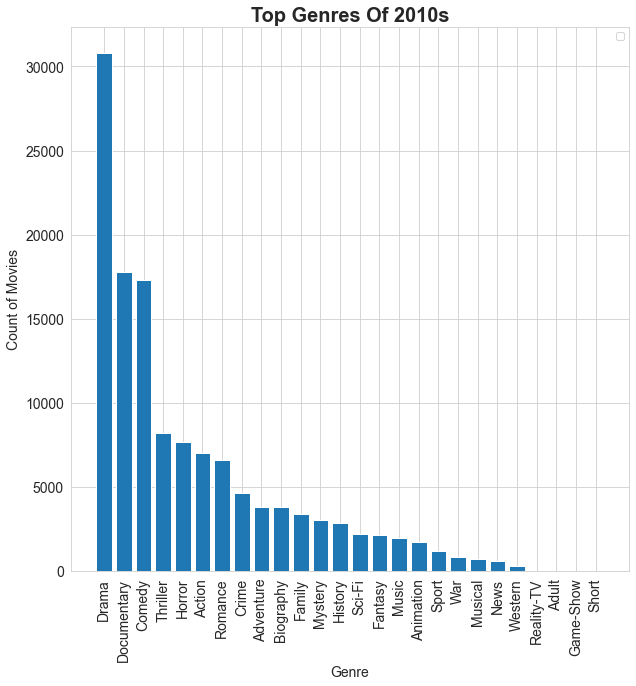

In [68]:
#Plot, note movies with multiple genres counted once for each genre
plt.figure (figsize=(10,10))
plt.bar(sorted_genre_count_dict.keys(), sorted_genre_count_dict.values())
plt.title('Top Genres Of 2010s', fontsize=20, fontweight="bold")
plt.xlabel('Genre', fontsize=14)
plt.xticks(rotation=90, fontsize=14)
plt.ylabel('Count of Movies', fontsize=14)
plt.yticks(fontsize=14)
plt.legend('')
plt.show()

In [69]:
# Zoom in on top 10 for presentation
genre_count_dict_zoom = {k: sorted_genre_count_dict[k] for k in list(sorted_genre_count_dict)[:10]}

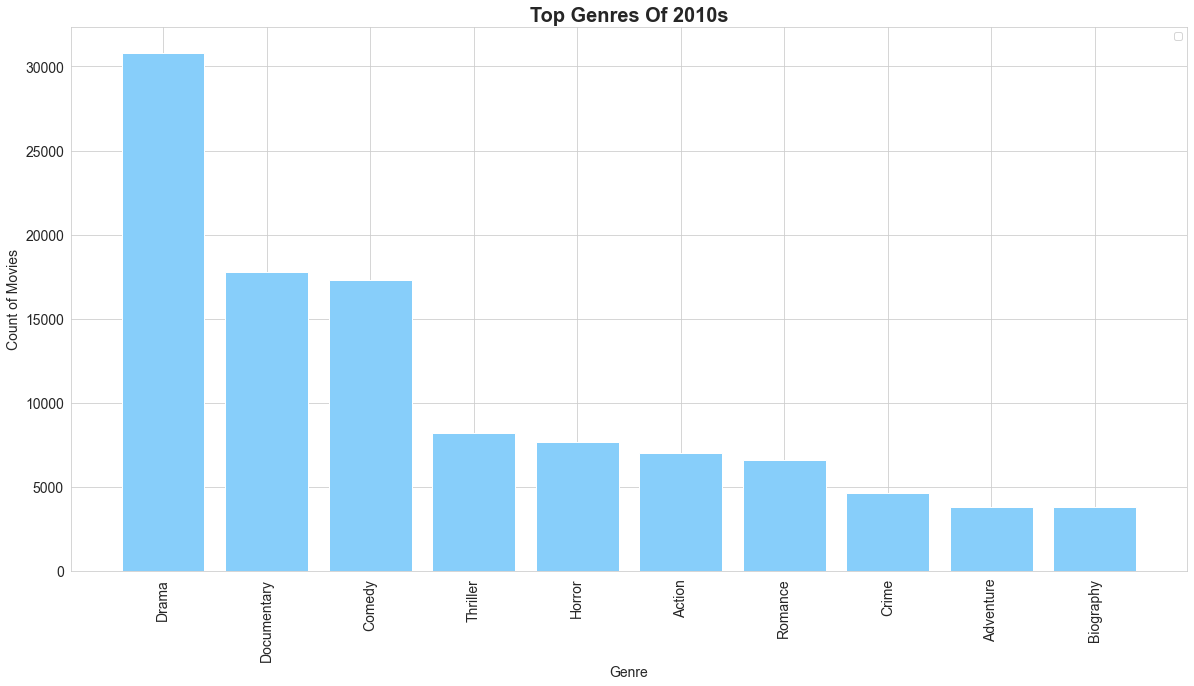

In [70]:
# Replot
plt.figure (figsize=(20,10))
plt.bar(genre_count_dict_zoom.keys(), genre_count_dict_zoom.values(), color='lightskyblue')
plt.title('Top Genres Of 2010s', fontsize=20, fontweight="bold")
plt.xlabel('Genre', fontsize=14)
plt.xticks(rotation=90, fontsize=14)
plt.ylabel('Count of Movies', fontsize=14)
plt.yticks(fontsize=14)
plt.legend('')
plt.savefig("images/1_bar_top_10_genres_2010s_lsb_wide.png")
plt.show()

## Of movies with financial data, look into production budget versus worldwide gross

In [71]:
# Create DataFrame with records that have production budget ROI data
imdb_all_prod_roi_genres = imdb_with_genre_cols[imdb_with_genre_cols['prod_budget_ROI'].notnull()]

In [72]:
imdb_all_prod_roi_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1498 entries, 18 to 73700
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title_year                1498 non-null   object 
 1   tconst                    1498 non-null   object 
 2   primary_title             1498 non-null   object 
 3   original_title            1498 non-null   object 
 4   start_year                1498 non-null   int64  
 5   runtime_minutes           1498 non-null   float64
 6   genres_x                  1498 non-null   object 
 7   averagerating             1498 non-null   float64
 8   numvotes                  1498 non-null   int64  
 9   directors                 1497 non-null   object 
 10  writers                   1480 non-null   object 
 11  genres_y                  1498 non-null   object 
 12  Music                     1498 non-null   int64  
 13  War                       1498 non-null   int64  
 14  Realit

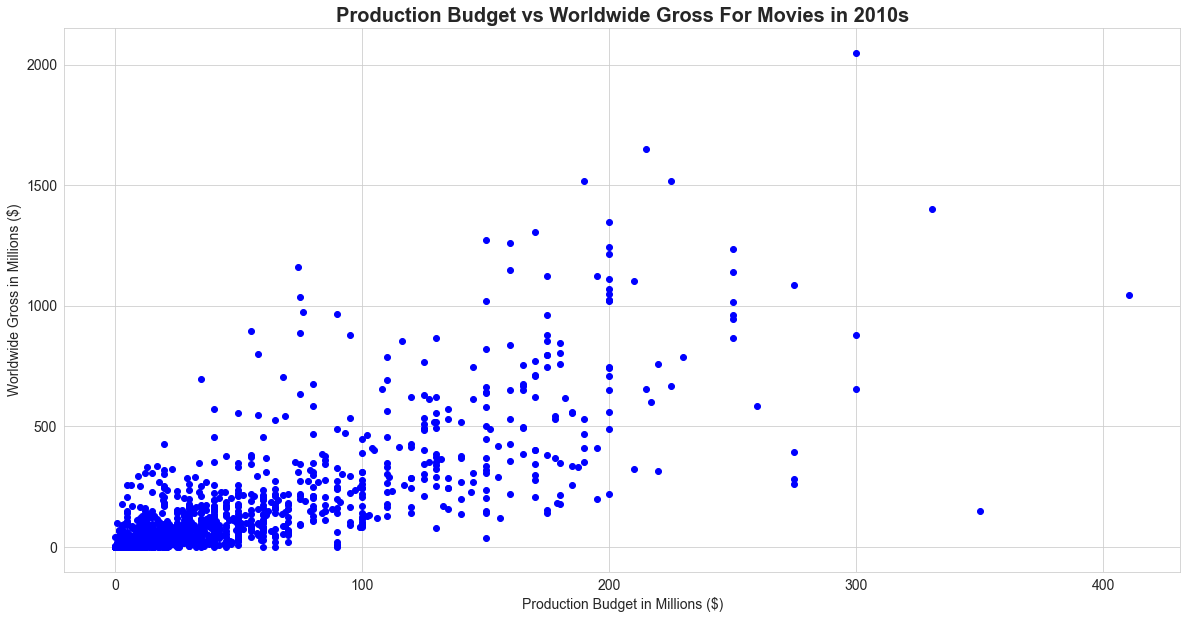

In [73]:
# Plot chart prod vs gross for all 2010 movies with financial data from table above
x = imdb_all_prod_roi_genres['production_budget_in_mil']
y = imdb_all_prod_roi_genres['worldwide_gross_in_mil']
plt.figure (figsize=(20,10))
plt.scatter(x, y, color='blue')
plt.title('Production Budget vs Worldwide Gross For Movies in 2010s', fontsize=20, fontweight="bold")
plt.xlabel('Production Budget in Millions ($)', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Worldwide Gross in Millions ($)', fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("images/additionalViz/scatter_prodbudg_vs_wwgross_2010s_all_fg_wide.png")
plt.show()

In [74]:
len(imdb_all_prod_roi_genres[imdb_all_prod_roi_genres['production_budget_in_mil'] <= 200])

1471

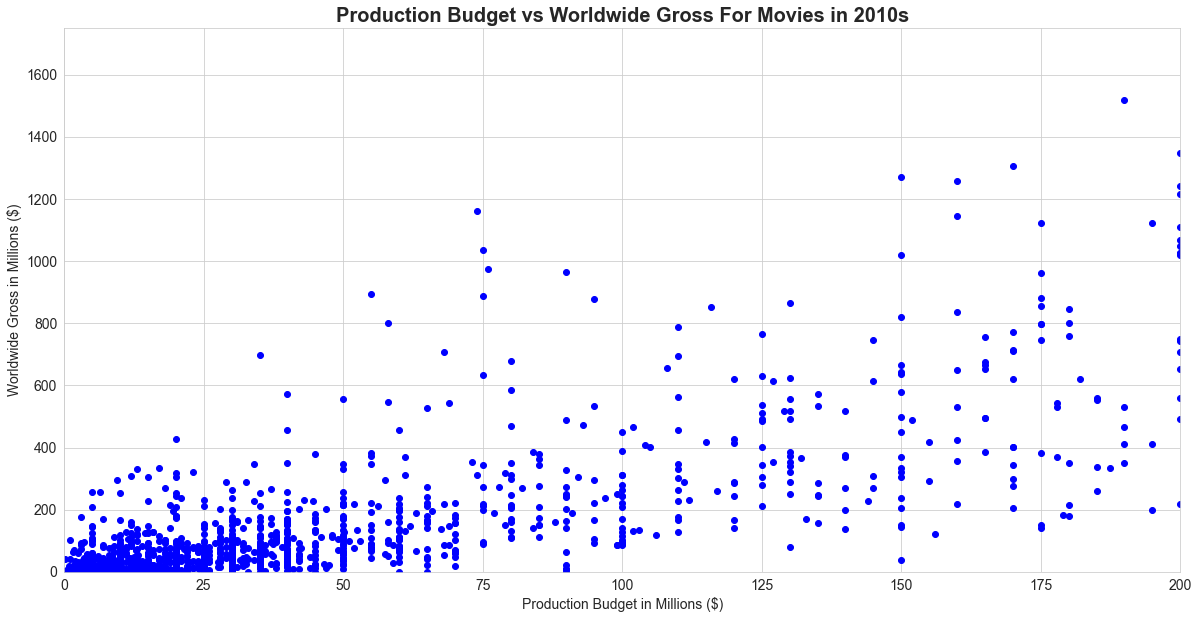

In [75]:
# Replot with zoom into production budget up to 200 mil 
x = imdb_all_prod_roi_genres['production_budget_in_mil']
y = imdb_all_prod_roi_genres['worldwide_gross_in_mil']
plt.figure (figsize=(20,10))
plt.scatter(x, y, color='blue')
plt.title('Production Budget vs Worldwide Gross For Movies in 2010s', fontsize=20, fontweight="bold")
plt.xlabel('Production Budget in Millions ($)', fontsize=14)
plt.xticks(fontsize=14)
plt.xlim(0,200)
plt.ylabel('Worldwide Gross in Millions ($)', fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0,1750)
plt.savefig("images/additionalViz/scatter_prodbudg_vs_wwgross_2010s_200M_fg_wide.png")
plt.show()

In [76]:
# Get list of genre columns
imdb_all_prod_roi_genres.columns[12:38]

Index(['Music', 'War', 'Reality-TV', 'Sport', 'Drama', 'Adventure',
       'Game-Show', 'Animation', 'History', 'Romance', 'Musical', 'News',
       'Mystery', 'Comedy', 'Documentary', 'Fantasy', 'Adult', 'Horror',
       'Crime', 'Family', 'Thriller', 'Western', 'Action', 'Short', 'Sci-Fi',
       'Biography'],
      dtype='object')

In [77]:
# Create list and assign variable name
genre_columns = list(imdb_all_prod_roi_genres.columns[13:38])

War


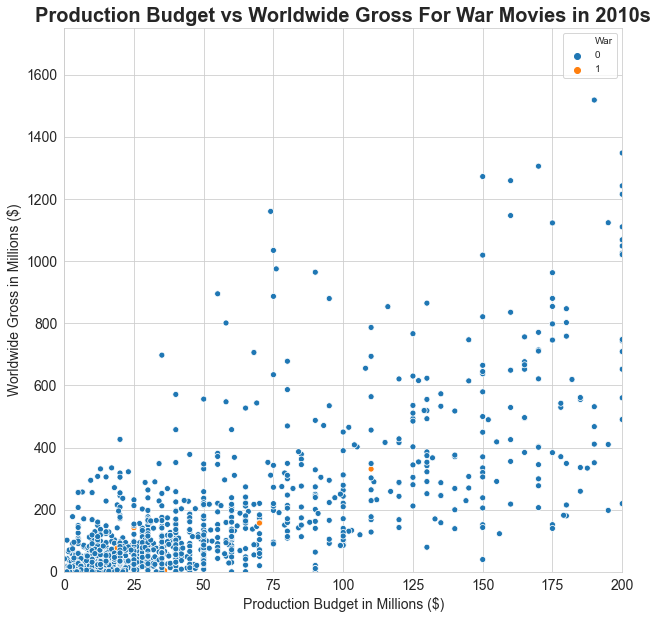

Reality-TV


<Figure size 432x288 with 0 Axes>

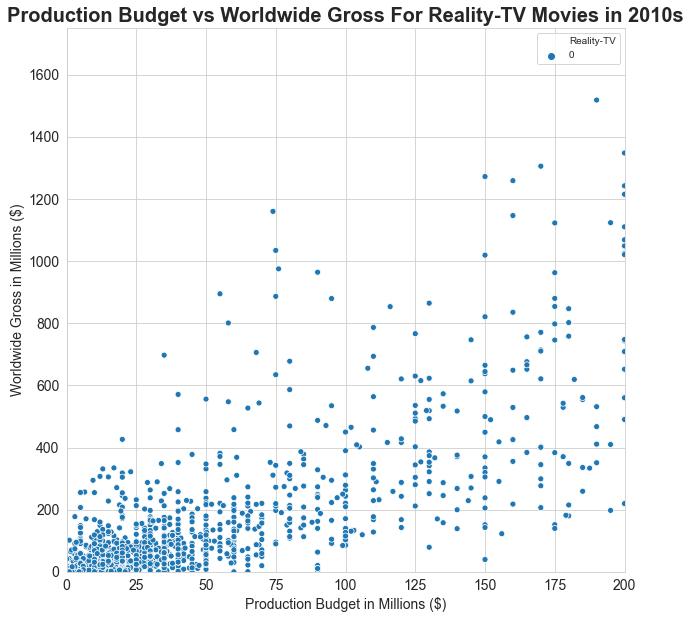

Sport


<Figure size 432x288 with 0 Axes>

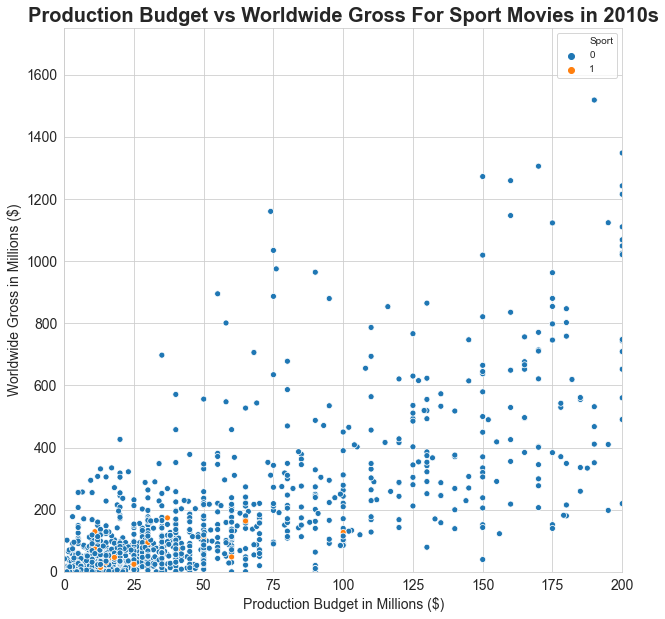

Drama


<Figure size 432x288 with 0 Axes>

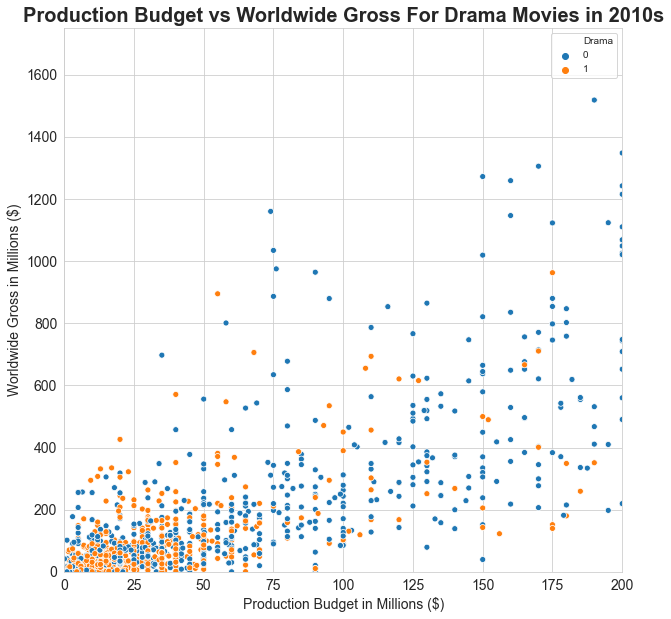

Adventure


<Figure size 432x288 with 0 Axes>

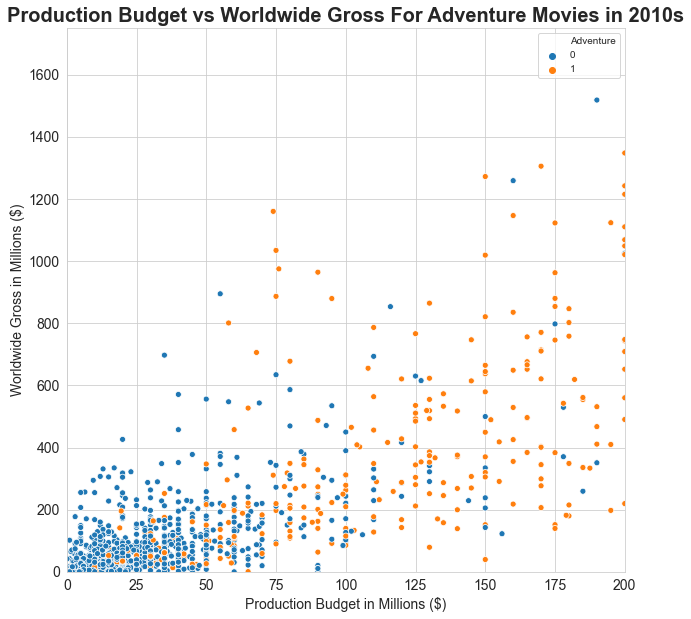

Game-Show


<Figure size 432x288 with 0 Axes>

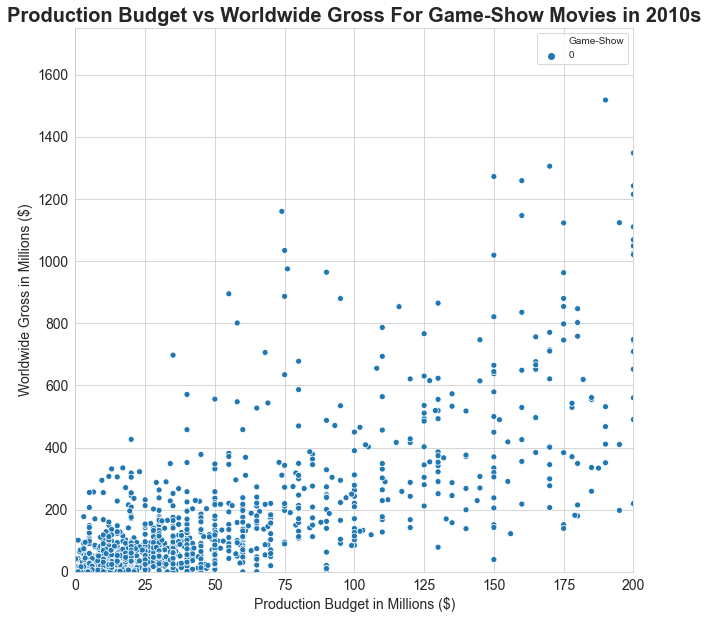

Animation


<Figure size 432x288 with 0 Axes>

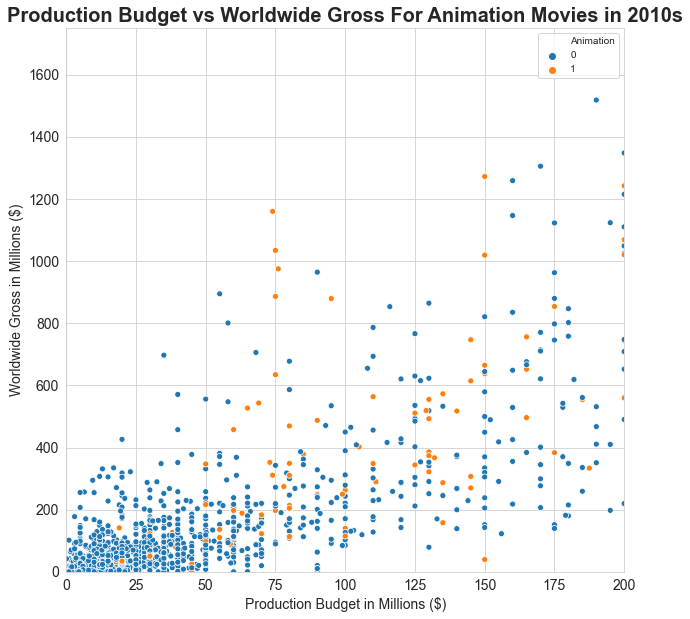

History


<Figure size 432x288 with 0 Axes>

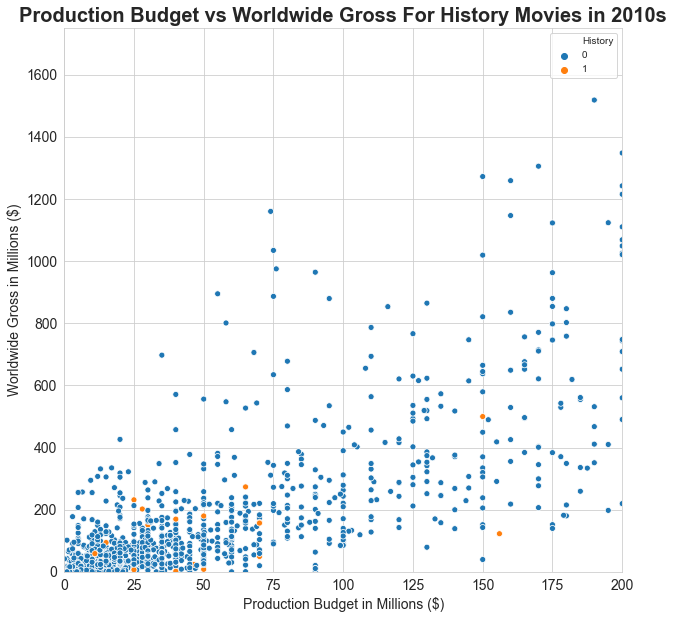

Romance


<Figure size 432x288 with 0 Axes>

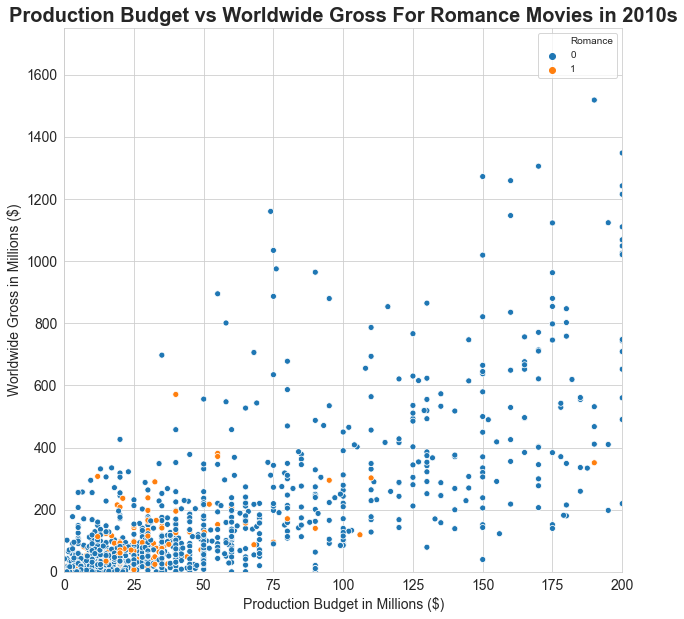

Musical


<Figure size 432x288 with 0 Axes>

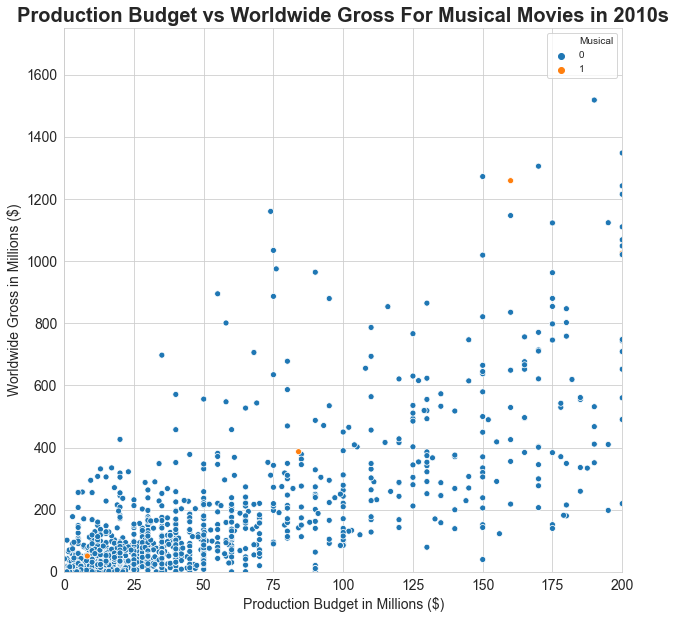

News


<Figure size 432x288 with 0 Axes>

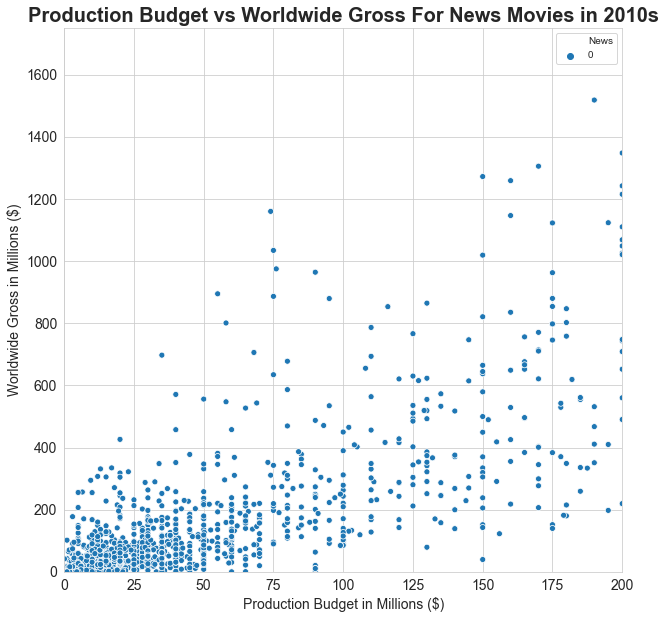

Mystery


<Figure size 432x288 with 0 Axes>

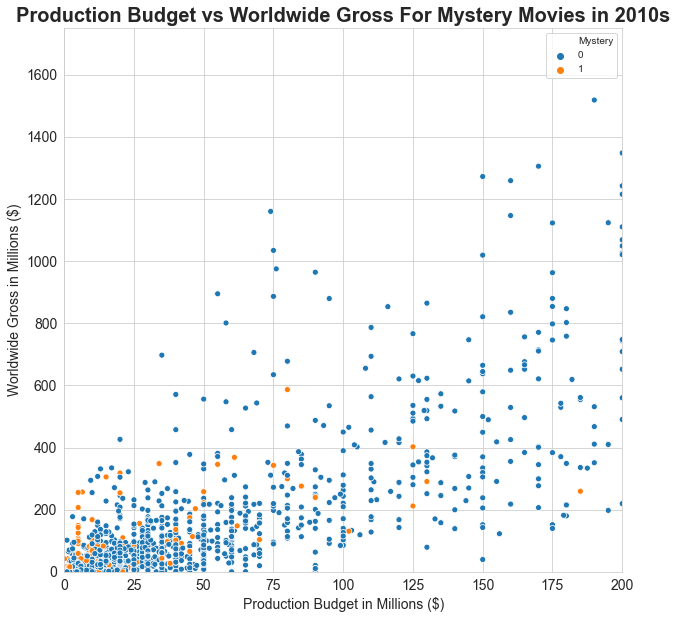

Comedy


<Figure size 432x288 with 0 Axes>

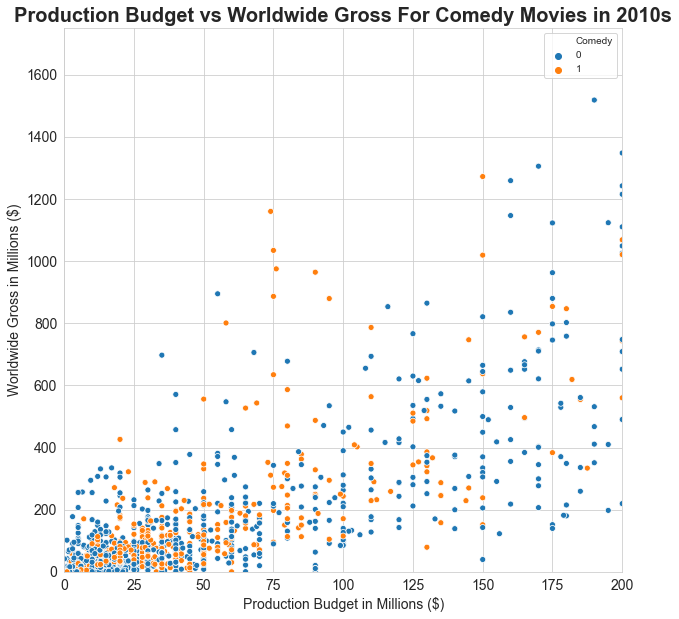

Documentary


<Figure size 432x288 with 0 Axes>

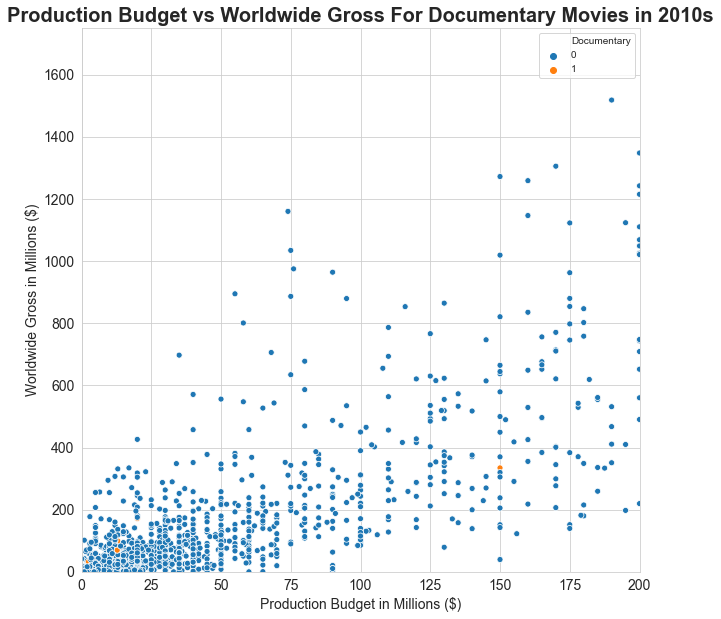

Fantasy


<Figure size 432x288 with 0 Axes>

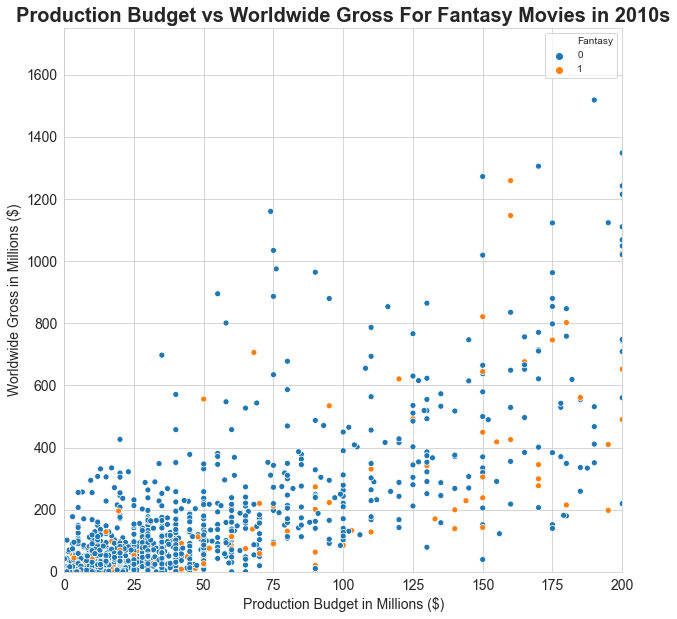

Adult


<Figure size 432x288 with 0 Axes>

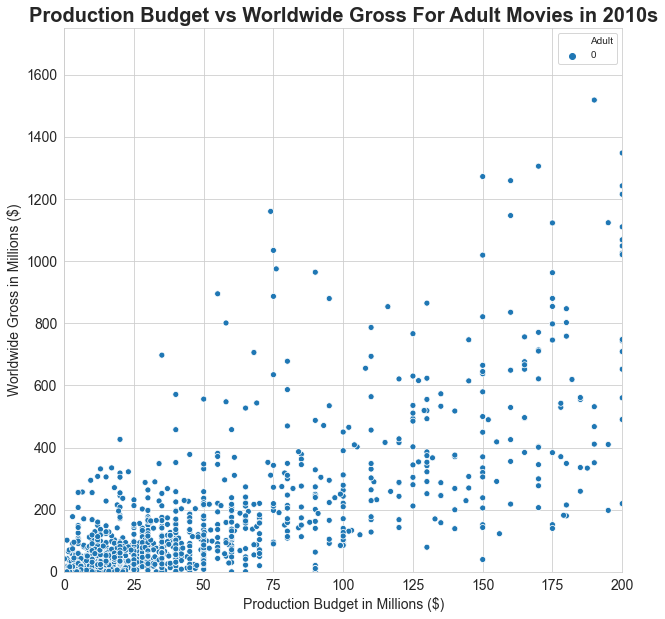

Horror


<Figure size 432x288 with 0 Axes>

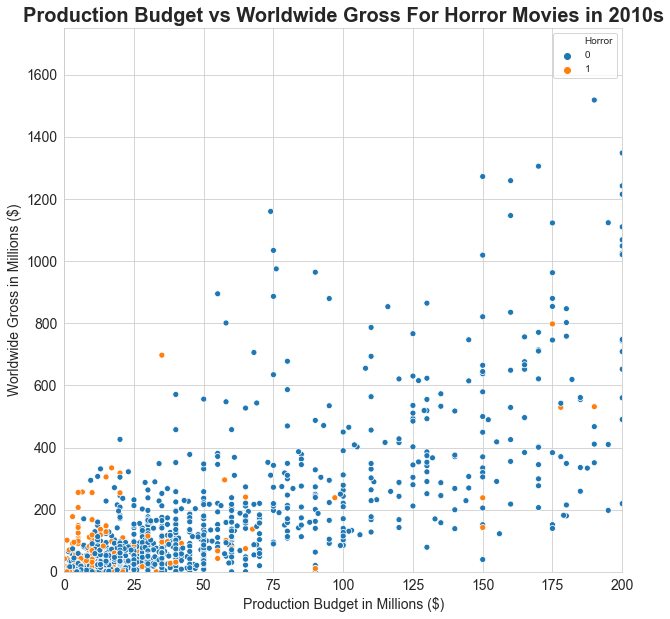

Crime


<Figure size 432x288 with 0 Axes>

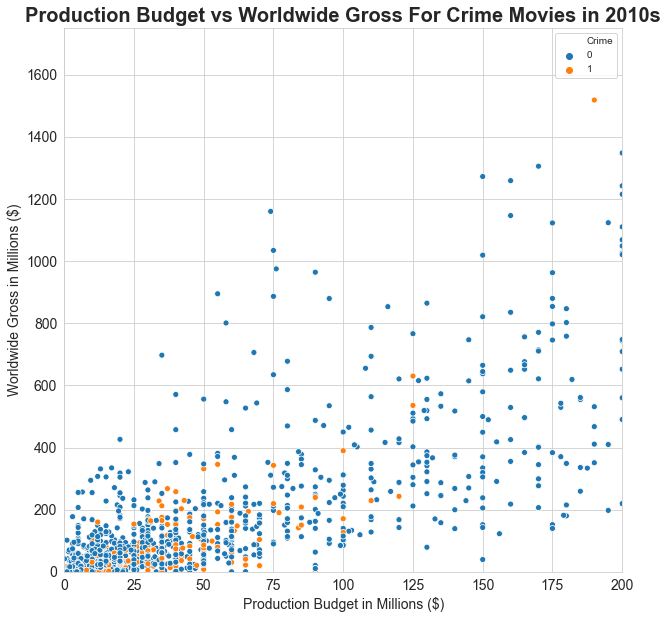

Family


<Figure size 432x288 with 0 Axes>

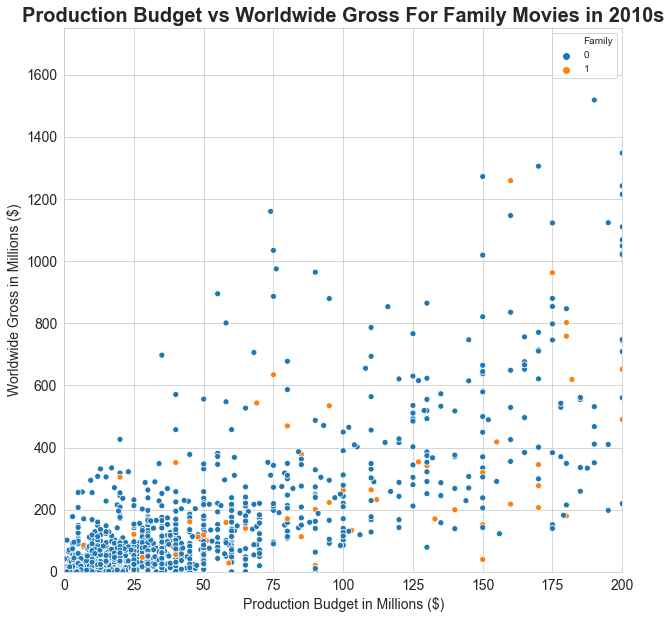

Thriller


<Figure size 432x288 with 0 Axes>

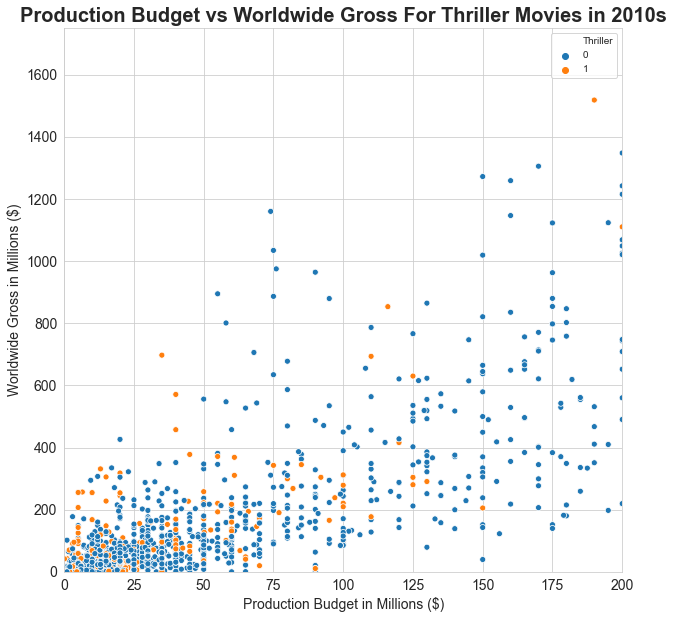

Western


<Figure size 432x288 with 0 Axes>

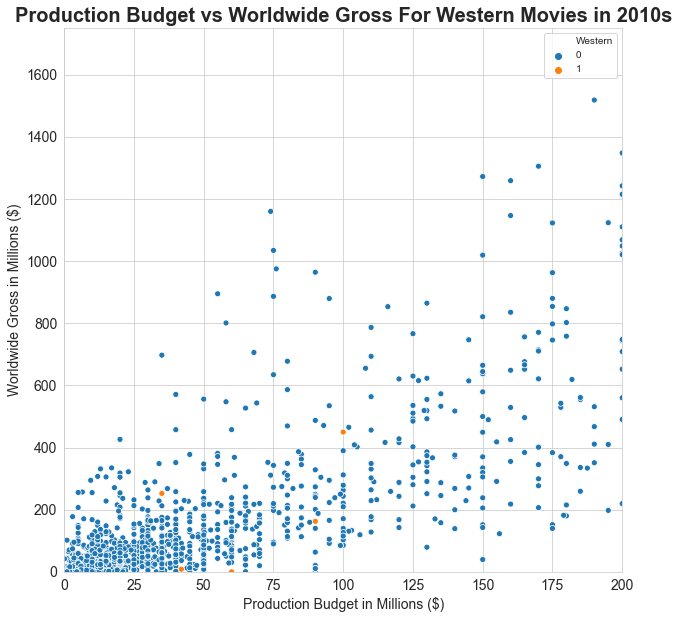

Action


<Figure size 432x288 with 0 Axes>

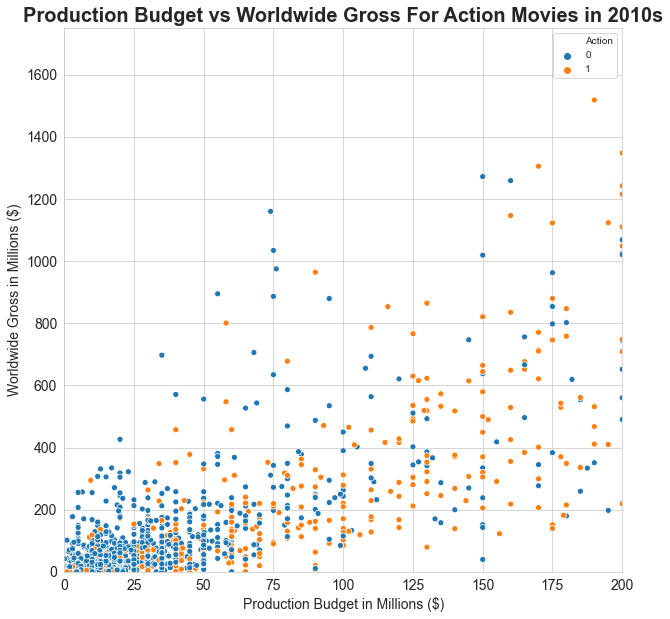

Short


<Figure size 432x288 with 0 Axes>

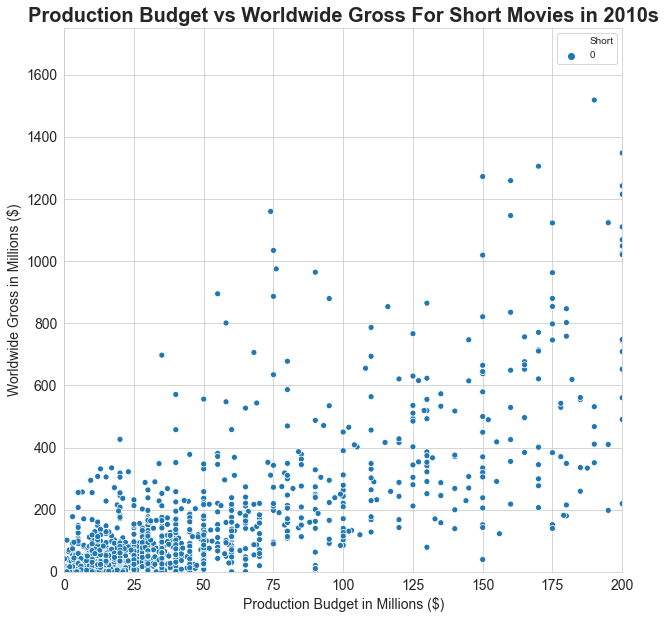

Sci-Fi


<Figure size 432x288 with 0 Axes>

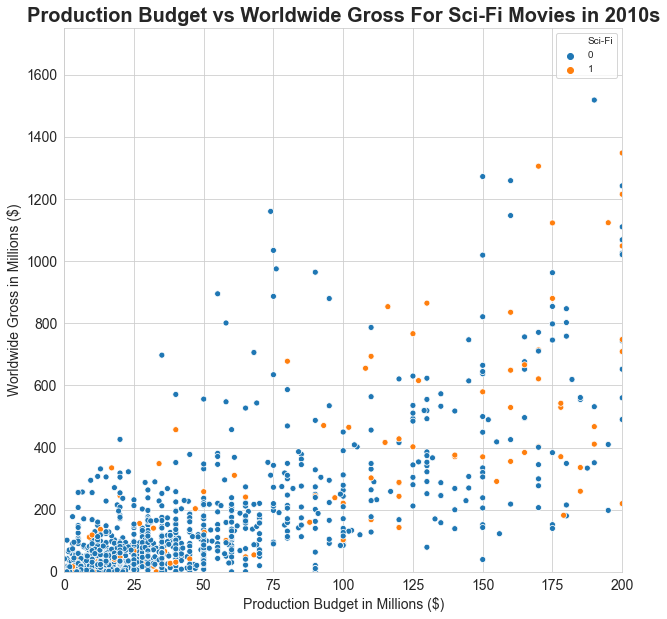

Biography


<Figure size 432x288 with 0 Axes>

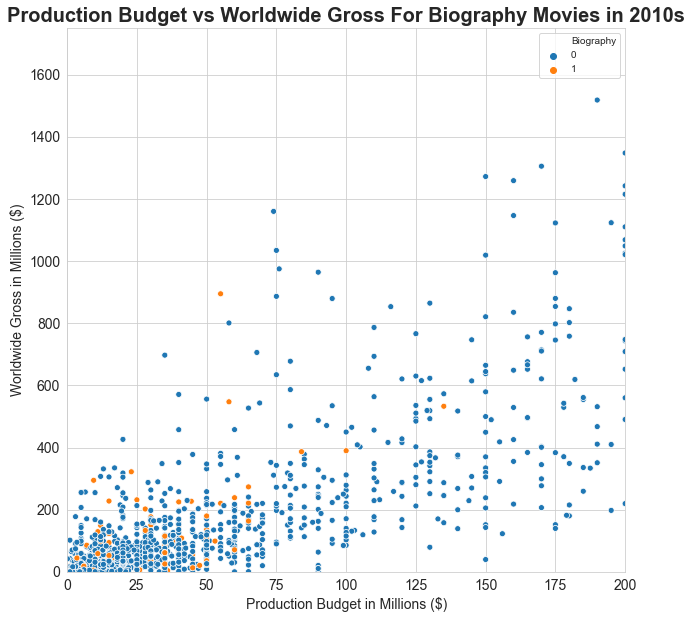

<Figure size 432x288 with 0 Axes>

In [78]:
# Use for loop to chart prod budget vs worldwide gross per genre
for genre in genre_columns:
    print(genre)
    x = imdb_all_prod_roi_genres['production_budget_in_mil']
    y = imdb_all_prod_roi_genres['worldwide_gross_in_mil']
    plt.figure (figsize=(10,10))
    sns.scatterplot(x, y, hue=imdb_all_prod_roi_genres[genre])
    plt.title(f'Production Budget vs Worldwide Gross For {genre} Movies in 2010s', fontsize=20, fontweight="bold")
    plt.xlabel('Production Budget in Millions ($)', fontsize=14)
    plt.xlim(0,200)
    plt.xticks(fontsize=14)
    plt.ylabel('Worldwide Gross in Millions ($)', fontsize=14)
    plt.ylim(0,1750)
    plt.yticks(fontsize=14)
    plt.show()
    plt.savefig(f"images/additionalViz/prod_budg_by_gross_genre/scatter_{genre}_prodbudg_vs_wwgross_2010s_200M_fg.png")

## Question 2: What is the best month to release a movie for highest worldwide gross?

In [79]:
imdb_all_prod_roi_genres.head()

,title_year,tconst,primary_title,original_title,start_year,runtime_minutes,genres_x,averagerating,numvotes,directors,...,worldwide_gross,release_year,worldwide_gross_in_mil,production_budget_in_mil,prod_budget_ROI,domestic_gross_in_mil,foreign_gross_in_mil,domestic_gross_p,foreign_gross_p,release_month
18,#Horror 2015,tt3526286,#Horror,#Horror,2015,101.0,"[Crime, Drama, Horror]",3.0,3092,nm0836964,...,0.0,2015,0.00,1.5,0.000000,0.00,0.00,0.60,0.40,Nov
168,10 Cloverfield Lane 2016,tt1179933,10 Cloverfield Lane,10 Cloverfield Lane,2016,103.0,"[Drama, Horror, Mystery]",7.2,260383,nm0870469,...,108286422.0,2016,108.29,5.0,21.658000,72.08,36.21,0.67,0.33,Mar
170,10 Days in a Madhouse 2015,tt3453052,10 Days in a Madhouse,10 Days in a Madhouse,2015,111.0,[Drama],6.7,1114,nm0385725,...,14616.0,2015,0.01,12.0,0.000833,0.01,0.00,1.00,0.00,Nov
319,12 Strong 2018,tt1413492,12 Strong,12 Strong,2018,130.0,"[Action, Drama, History]",6.6,50155,nm3350420,...,71118378.0,2018,71.12,35.0,2.032000,45.82,25.30,0.64,0.36,Jan
321,12 Years a Slave 2013,tt2024544,12 Years a Slave,12 Years a Slave,2013,134.0,"[Biography, Drama, History]",8.1,577301,nm2588606,...,181025343.0,2013,181.03,20.0,9.051500,56.67,124.36,0.31,0.69,Oct


In [80]:
# Reset index
imdb_all_prod_roi_genres = imdb_all_prod_roi_genres.reset_index()

In [81]:
# View table
imdb_all_prod_roi_genres

,index,title_year,tconst,primary_title,original_title,start_year,runtime_minutes,genres_x,averagerating,numvotes,...,worldwide_gross,release_year,worldwide_gross_in_mil,production_budget_in_mil,prod_budget_ROI,domestic_gross_in_mil,foreign_gross_in_mil,domestic_gross_p,foreign_gross_p,release_month
0,18,#Horror 2015,tt3526286,#Horror,#Horror,2015,101.0,"[Crime, Drama, Horror]",3.0,3092,...,0.000000e+00,2015,0.00,1.5,0.000000,0.00,0.00,0.60,0.40,Nov
1,168,10 Cloverfield Lane 2016,tt1179933,10 Cloverfield Lane,10 Cloverfield Lane,2016,103.0,"[Drama, Horror, Mystery]",7.2,260383,...,1.082864e+08,2016,108.29,5.0,21.658000,72.08,36.21,0.67,0.33,Mar
2,170,10 Days in a Madhouse 2015,tt3453052,10 Days in a Madhouse,10 Days in a Madhouse,2015,111.0,[Drama],6.7,1114,...,1.461600e+04,2015,0.01,12.0,0.000833,0.01,0.00,1.00,0.00,Nov
3,319,12 Strong 2018,tt1413492,12 Strong,12 Strong,2018,130.0,"[Action, Drama, History]",6.6,50155,...,7.111838e+07,2018,71.12,35.0,2.032000,45.82,25.30,0.64,0.36,Jan
4,321,12 Years a Slave 2013,tt2024544,12 Years a Slave,12 Years a Slave,2013,134.0,"[Biography, Drama, History]",8.1,577301,...,1.810253e+08,2013,181.03,20.0,9.051500,56.67,124.36,0.31,0.69,Oct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,73597,Zookeeper 2011,tt1222817,Zookeeper,Zookeeper,2011,102.0,"[Comedy, Family, Romance]",5.2,52396,...,1.708055e+08,2011,170.81,80.0,2.135125,80.36,90.45,0.47,0.53,Jul
1494,73598,Zoolander 2 2016,tt1608290,Zoolander 2,Zoolander 2,2016,101.0,[Comedy],4.7,59914,...,5.534869e+07,2016,55.35,50.0,1.107000,28.85,26.50,0.52,0.48,Feb
1495,73608,Zootopia 2016,tt2948356,Zootopia,Zootopia,2016,108.0,"[Adventure, Animation, Comedy]",8.0,383446,...,1.019430e+09,2016,1019.43,150.0,6.796200,341.27,678.16,0.33,0.67,Mar
1496,73625,Zulu 2013,tt2249221,Zulu,Zulu,2013,110.0,"[Crime, Drama, Thriller]",6.7,16607,...,1.844228e+06,2013,1.84,16.0,0.115000,0.00,1.84,0.00,1.00,Dec


In [82]:
# View info
imdb_all_prod_roi_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 54 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     1498 non-null   int64  
 1   title_year                1498 non-null   object 
 2   tconst                    1498 non-null   object 
 3   primary_title             1498 non-null   object 
 4   original_title            1498 non-null   object 
 5   start_year                1498 non-null   int64  
 6   runtime_minutes           1498 non-null   float64
 7   genres_x                  1498 non-null   object 
 8   averagerating             1498 non-null   float64
 9   numvotes                  1498 non-null   int64  
 10  directors                 1497 non-null   object 
 11  writers                   1480 non-null   object 
 12  genres_y                  1498 non-null   object 
 13  Music                     1498 non-null   int64  
 14  War     

In [83]:
# Look at release_date values
imdb_all_prod_roi_genres['release_date']

0       Nov 20, 2015
1       Mar 11, 2016
2       Nov 11, 2015
3       Jan 19, 2018
4       Oct 18, 2013
            ...     
1493     Jul 8, 2011
1494    Feb 12, 2016
1495     Mar 4, 2016
1496    Dec 31, 2013
1497    Jan 20, 2017
Name: release_date, Length: 1498, dtype: object

In [84]:
# Convert release_date values to date time 
imdb_all_prod_roi_genres['release_date'] = pd.to_datetime(imdb_all_prod_roi_genres['release_date'])

In [85]:
# Review new values
imdb_all_prod_roi_genres['release_date']

0      2015-11-20
1      2016-03-11
2      2015-11-11
3      2018-01-19
4      2013-10-18
          ...    
1493   2011-07-08
1494   2016-02-12
1495   2016-03-04
1496   2013-12-31
1497   2017-01-20
Name: release_date, Length: 1498, dtype: datetime64[ns]

## What is best month to release a movie?

In [86]:
# Pull out month from date time value
imdb_all_prod_roi_genres['release_month_number'] = imdb_all_prod_roi_genres['release_date'].dt.month

In [87]:
imdb_all_prod_roi_genres['release_month_number']

0       11
1        3
2       11
3        1
4       10
        ..
1493     7
1494     2
1495     3
1496    12
1497     1
Name: release_month_number, Length: 1498, dtype: int64

In [88]:
imdb_all_prod_roi_genres_mon = imdb_all_prod_roi_genres.groupby(['release_month_number'])['worldwide_gross_in_mil'].agg(['sum']).reset_index()

In [89]:
imdb_all_prod_roi_genres_mon

,release_month_number,sum
0,1,5654.15
1,2,12884.42
2,3,20920.30
3,4,14778.52
4,5,24474.02
5,6,27466.34
6,7,23893.14
7,8,11378.60
8,9,9804.44
9,10,12160.59


In [90]:
# Replace release_month_number with name of month. There's a more efficient way to do this.
for row in imdb_all_prod_roi_genres_mon.index:
    if imdb_all_prod_roi_genres_mon['release_month_number'][row] == 1:
        imdb_all_prod_roi_genres_mon['release_month_number'][row] = 'January'
    elif imdb_all_prod_roi_genres_mon['release_month_number'][row] == 2:
        imdb_all_prod_roi_genres_mon['release_month_number'][row] = 'February'
    elif imdb_all_prod_roi_genres_mon['release_month_number'][row] == 3:
        imdb_all_prod_roi_genres_mon['release_month_number'][row] = 'March'
    elif imdb_all_prod_roi_genres_mon['release_month_number'][row] == 4:
        imdb_all_prod_roi_genres_mon['release_month_number'][row] = 'April'
    elif imdb_all_prod_roi_genres_mon['release_month_number'][row] == 5:
        imdb_all_prod_roi_genres_mon['release_month_number'][row] = 'May'
    elif imdb_all_prod_roi_genres_mon['release_month_number'][row] == 6:
        imdb_all_prod_roi_genres_mon['release_month_number'][row] = 'June'
    elif imdb_all_prod_roi_genres_mon['release_month_number'][row] == 7:
        imdb_all_prod_roi_genres_mon['release_month_number'][row] = 'July'
    elif imdb_all_prod_roi_genres_mon['release_month_number'][row] == 8:
        imdb_all_prod_roi_genres_mon['release_month_number'][row] = 'August'  
    elif imdb_all_prod_roi_genres_mon['release_month_number'][row] == 9:
        imdb_all_prod_roi_genres_mon['release_month_number'][row] = 'September'
    elif imdb_all_prod_roi_genres_mon['release_month_number'][row] == 10:
        imdb_all_prod_roi_genres_mon['release_month_number'][row] = 'October'
    elif imdb_all_prod_roi_genres_mon['release_month_number'][row] == 11:
        imdb_all_prod_roi_genres_mon['release_month_number'][row] = 'November'
    else:
        imdb_all_prod_roi_genres_mon['release_month_number'][row] = 'December'

<ipython-input-90-8aa5e037843c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_all_prod_roi_genres_mon['release_month_number'][row] = 'January'
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-90-8aa5e037843c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_all_prod_roi_genres_mon['release_month_nu

In [91]:
imdb_all_prod_roi_genres_mon

,release_month_number,sum
0,January,5654.15
1,February,12884.42
2,March,20920.30
3,April,14778.52
4,May,24474.02
5,June,27466.34
6,July,23893.14
7,August,11378.60
8,September,9804.44
9,October,12160.59


In [92]:
# Rename column release_month_number and sum
imdb_all_prod_roi_genres_mon = imdb_all_prod_roi_genres_mon.rename(columns={"release_month_number": "release_month_name", "sum": "worldwide_gross_in_mil_sum"})

In [93]:
imdb_all_prod_roi_genres_mon

,release_month_name,worldwide_gross_in_mil_sum
0,January,5654.15
1,February,12884.42
2,March,20920.30
3,April,14778.52
4,May,24474.02
5,June,27466.34
6,July,23893.14
7,August,11378.60
8,September,9804.44
9,October,12160.59


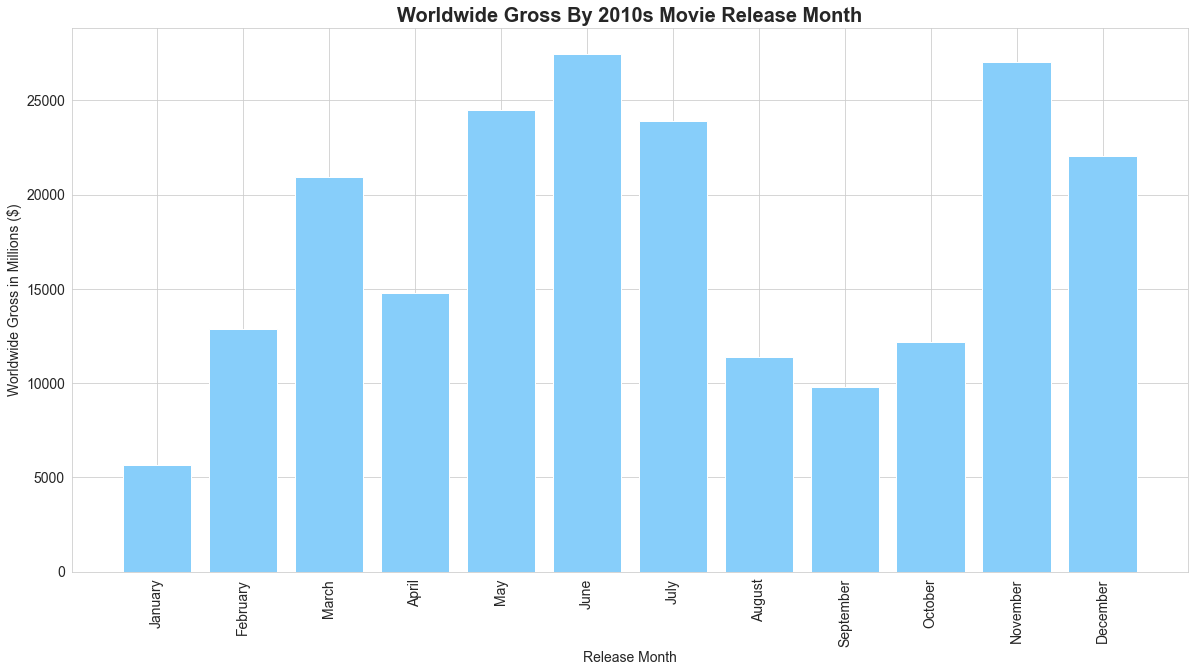

In [94]:
x = imdb_all_prod_roi_genres_mon['release_month_name']
y = imdb_all_prod_roi_genres_mon['worldwide_gross_in_mil_sum']
plt.figure (figsize=(20,10))
plt.bar(x, y, color='lightskyblue')
plt.title('Worldwide Gross By 2010s Movie Release Month', fontsize=20, fontweight="bold")
plt.xlabel('Release Month', fontsize=14)
plt.xticks(rotation=90, fontsize=14)
plt.ylabel('Worldwide Gross in Millions ($)', fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("images/2_bar_release_months_by_wwgross_lsb_wide.png")
plt.show()

# n=1498

### Learning: June and November are top months for worldwide gross – summer blockbuster, thanksgiving/holiday release

## Question 3: Of movies that breakeven (ROI >= 1), what genres are most represented?

In [95]:
# Define new DataFrame with prod_ROI >=1
imdb_prodROI_breakeven = imdb_with_genre_cols[imdb_with_genre_cols['prod_budget_ROI'] >= 1]

In [96]:
# Check new table; 1049 movies represented
imdb_prodROI_breakeven.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1049 entries, 168 to 73700
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title_year                1049 non-null   object 
 1   tconst                    1049 non-null   object 
 2   primary_title             1049 non-null   object 
 3   original_title            1049 non-null   object 
 4   start_year                1049 non-null   int64  
 5   runtime_minutes           1049 non-null   float64
 6   genres_x                  1049 non-null   object 
 7   averagerating             1049 non-null   float64
 8   numvotes                  1049 non-null   int64  
 9   directors                 1048 non-null   object 
 10  writers                   1042 non-null   object 
 11  genres_y                  1049 non-null   object 
 12  Music                     1049 non-null   int64  
 13  War                       1049 non-null   int64  
 14  Reali

In [97]:
# Create DataFrame for genre ROI analysis
imdb_prodROI_breakeven_genres = imdb_prodROI_breakeven[genre_name_list]

In [98]:
# Check work
imdb_prodROI_breakeven_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1049 entries, 168 to 73700
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Music        1049 non-null   int64
 1   War          1049 non-null   int64
 2   Reality-TV   1049 non-null   int64
 3   Sport        1049 non-null   int64
 4   Drama        1049 non-null   int64
 5   Adventure    1049 non-null   int64
 6   Game-Show    1049 non-null   int64
 7   Animation    1049 non-null   int64
 8   History      1049 non-null   int64
 9   Romance      1049 non-null   int64
 10  Musical      1049 non-null   int64
 11  News         1049 non-null   int64
 12  Mystery      1049 non-null   int64
 13  Comedy       1049 non-null   int64
 14  Documentary  1049 non-null   int64
 15  Fantasy      1049 non-null   int64
 16  Adult        1049 non-null   int64
 17  Horror       1049 non-null   int64
 18  Crime        1049 non-null   int64
 19  Family       1049 non-null   int64
 20  Thril

In [99]:
for genre_column in imdb_prodROI_breakeven_genres:
    print(genre_column, imdb_prodROI_breakeven_genres[genre_column].sum())

Music 36
War 7
Reality-TV 0
Sport 22
Drama 471
Adventure 296
Game-Show 0
Animation 91
History 25
Romance 139
Musical 5
News 0
Mystery 92
Comedy 391
Documentary 22
Fantasy 95
Adult 0
Horror 115
Crime 151
Family 71
Thriller 179
Western 4
Action 326
Short 0
Sci-Fi 102
Biography 88


In [100]:
prodROI_genres = []
prodROI_counts = []

for genre_column in imdb_prodROI_breakeven_genres:
    prodROI_genres.append(genre_column)
    prodROI_counts.append(imdb_prodROI_breakeven_genres[genre_column].sum())

In [101]:
prodROI_genres

['Music',
 'War',
 'Reality-TV',
 'Sport',
 'Drama',
 'Adventure',
 'Game-Show',
 'Animation',
 'History',
 'Romance',
 'Musical',
 'News',
 'Mystery',
 'Comedy',
 'Documentary',
 'Fantasy',
 'Adult',
 'Horror',
 'Crime',
 'Family',
 'Thriller',
 'Western',
 'Action',
 'Short',
 'Sci-Fi',
 'Biography']

In [102]:
prodROI_counts

[36,
 7,
 0,
 22,
 471,
 296,
 0,
 91,
 25,
 139,
 5,
 0,
 92,
 391,
 22,
 95,
 0,
 115,
 151,
 71,
 179,
 4,
 326,
 0,
 102,
 88]

In [103]:
# Create DataFrame for plotting
prodROI_genre_counts = list(zip(prodROI_genres, prodROI_counts)) 
  
# Assign data to tuples. 
prodROI_genre_counts

# Create DataFrame
prodROI_genre_counts = pd.DataFrame(prodROI_genre_counts, columns = ['genre', 'count'])
prodROI_genre_counts = prodROI_genre_counts.sort_values(by='count', ascending=False)
prodROI_genre_counts 

,genre,count
4,Drama,471
13,Comedy,391
22,Action,326
5,Adventure,296
20,Thriller,179
18,Crime,151
9,Romance,139
17,Horror,115
24,Sci-Fi,102
15,Fantasy,95


In [104]:
# Filter out Unknown genre and any genre with 0 count
prodROI_genre_counts = prodROI_genre_counts[prodROI_genre_counts['count'] >=4]

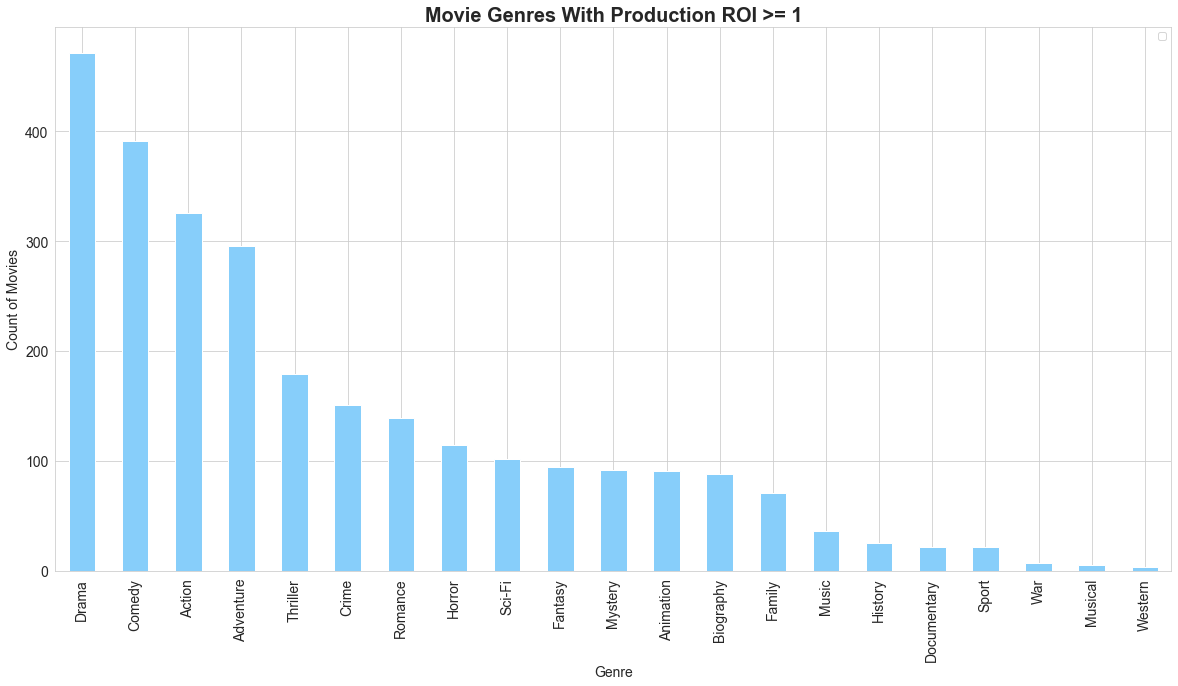

In [105]:
# Plot bar chart of top genre counts in the table
prodROI_genre_counts.plot(kind='bar', x='genre', y='count', figsize = (20,10), color='lightskyblue')
plt.title('Movie Genres With Production ROI >= 1', fontsize=20, fontweight="bold")
plt.xlabel('Genre', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Count of Movies', fontsize=14)
plt.yticks(fontsize=14)
plt.legend('')
plt.savefig('images/3_bar_genres_with_roi_breakeven_wide.png')

### Learning: Of movie genres that make their budget back - Drama, Comedy, Action, Adventure, and Thriller are top 5

## Question 4: Based on production budget and average ratings, what genres are the best investments?

Explore Drama

In [106]:
# Create DataFrame for Drama records
imdb_with_genre_cols_drama = imdb_with_genre_cols[imdb_with_genre_cols['Drama'] == 1]

In [107]:
# Look at stats for prod budget to look at investment needs
imdb_with_genre_cols_drama['production_budget_in_mil'].describe()

count    726.000000
mean      26.595771
std       32.402310
min        0.020000
25%        6.125000
50%       17.000000
75%       35.000000
max      210.000000
Name: production_budget_in_mil, dtype: float64

In [108]:
# What is average rating for Drama movies according to IMDB data
imdb_with_genre_cols_drama['averagerating'].mean()

6.401559048980189

In [109]:
#Define top genres
imdb_genre_names = ['Drama', 'Comedy', 'Action', 'Adventure', 'Thriller']

# Create for loop to do the above for each top genre and print results
for genre in imdb_genre_names:
        print(f"{genre}:")
        genre_table = imdb_with_genre_cols[imdb_with_genre_cols[genre] == 1]
        print(f"median production budget: {genre_table['production_budget_in_mil'].median()}")
        print(f"average rating: {(round(genre_table['averagerating'].mean(), 1))}")

Drama:
median production budget: 17.0
average rating: 6.4
Comedy:
median production budget: 25.5
average rating: 6.0
Action:
median production budget: 58.0
average rating: 5.8
Adventure:
median production budget: 100.0
average rating: 6.2
Thriller:
median production budget: 20.0
average rating: 5.6


In [110]:
## Create DF to visualize median production budgets
imdb_genre_names = ["Drama", "Comedy", "Action", "Adventure", "Thriller"] 
imdb_genre_budgets = [17.0, 25.5, 58.0, 100.0, 20.0] 


# Create DataFrame for plotting
imdb_top_genre_prodbudgmed = list(zip(imdb_genre_names, imdb_genre_budgets)) 
  
# Assign data to tuples. 
imdb_top_genre_prodbudgmed

# Create DF
imdb_top_genre_prodbudgmed = pd.DataFrame(imdb_top_genre_prodbudgmed, columns = ['genre', 'median_prod_budg_in_mil'])
imdb_top_genre_prodbudgmed

,genre,median_prod_budg_in_mil
0,Drama,17.0
1,Comedy,25.5
2,Action,58.0
3,Adventure,100.0
4,Thriller,20.0


In [111]:
# Also need average rating, adding on
imdb_top_genre_prodbudgmed['average_rating'] = [6.4, 6.0, 5.8, 6.2, 5.6]

In [112]:
# Preview new DataFrame
imdb_top_genre_prodbudgmed

,genre,median_prod_budg_in_mil,average_rating
0,Drama,17.0,6.4
1,Comedy,25.5,6.0
2,Action,58.0,5.8
3,Adventure,100.0,6.2
4,Thriller,20.0,5.6


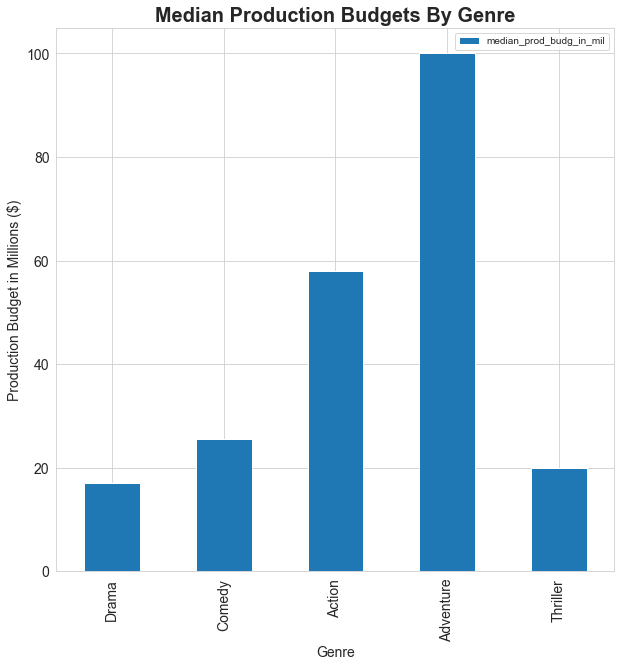

In [113]:
# Plot
imdb_top_genre_prodbudgmed.plot(kind='bar', x='genre', y='median_prod_budg_in_mil', figsize = (10,10))
plt.title('Median Production Budgets By Genre', fontsize=20, fontweight="bold")
plt.xlabel('Genre', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Production Budget in Millions ($)', fontsize=14)
plt.yticks(fontsize=14)
plt.show()

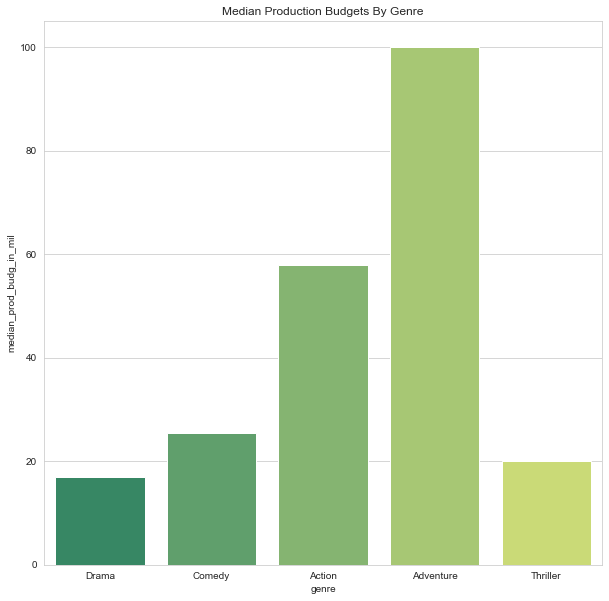

In [114]:
# Edit plot - draft for presentation
plt.figure(figsize=(10,10))
plt.title('Median Production Budgets By Genre')
sns.barplot(x='genre', y='median_prod_budg_in_mil', data=imdb_top_genre_prodbudgmed, palette='summer')
plt.show()

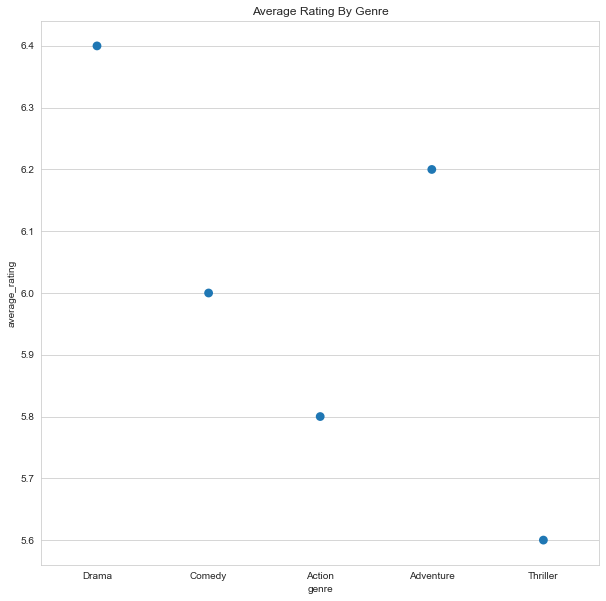

In [115]:
# Plot average ratings 
plt.figure(figsize=(10,10))
plt.title('Average Rating By Genre')
sns.pointplot(x='genre', y='average_rating', data=imdb_top_genre_prodbudgmed, join=False)
plt.show()

In [116]:
len(imdb_top_genre_prodbudgmed)

5

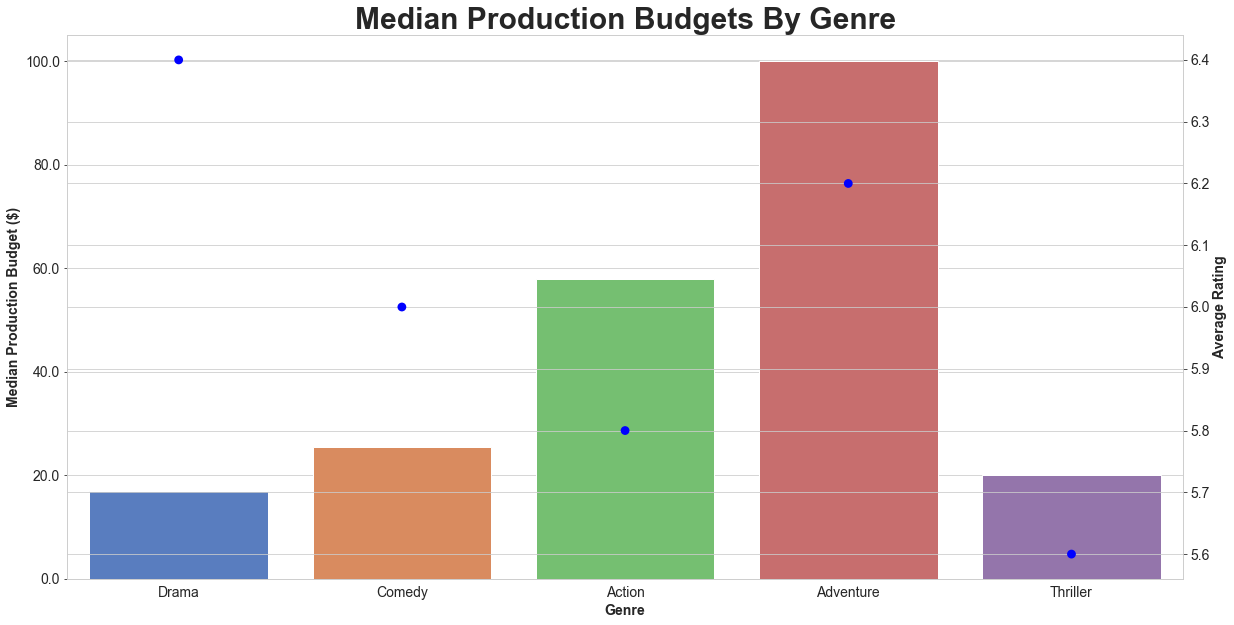

In [117]:
# Create combo chart measuring median Prod Budget ROI by genre with an overlay of average rating
# Looking for most white space between budget and rating showing that budget was low and rating was high
fig, ax1 = plt.subplots(figsize=(20,10))
#bar plot creation
ax1.set_title('Median Production Budgets By Genre', fontsize=30, fontweight="bold")
sns.barplot(x='genre', y='median_prod_budg_in_mil', data=imdb_top_genre_prodbudgmed, palette='muted')
ax1.set_xlabel('Genre', fontsize=14, fontweight='bold')
ax1.set_xticklabels(ax1.get_xticks(), size=14)
ax1.set_ylabel('Median Production Budget ($)', fontsize=14, fontweight='bold')
ax1.set_yticklabels(ax1.get_yticks(), size=14)
ax1.tick_params(axis='y')
#specify we want to share the same x-axis
ax2 = ax1.twinx()
#line plot creation
ax2 = sns.pointplot(x='genre', y='average_rating', data=imdb_top_genre_prodbudgmed, join=False, color='blue')
ax2.set_ylabel('Average Rating', fontsize=14, fontweight='bold')
ax2.set_yticklabels(ax2.get_yticks(), size=14)
ax2.tick_params(axis='y')
#save plot
plt.savefig("images/4_combo_genre_prod_budg_with_rating_wide.png")
#show plot
plt.show()

### Learning: Drama in cheapest to produce with highest average rating


Data Review: 
Drama is cheapest to produce and most likely to return ROI; Comedy is next best
Thrillers also less money, but have lowest average rating Drama and Adventure have highest average rating, but Adventure 5.8x more to produce

Business rec: 
If money is a concern, best investment would be in Dramas. Next best investment would be in Comedy.
If up front money is not a concern, then can consider Adventure or Action movies. Adventure is 2x the production budget, so depending on how much budget there is, Action is the more conservative choice of the two.

## Question 5: For the breakeven movies that fall into these genres, what is the recommended runtime and who are the highest rated directors?

In [118]:
# Create new DataFrame for known Drama Directors
imdb_drama_writ_dir = imdb_with_genre_cols[(imdb_with_genre_cols['Drama'] == 1) & (imdb_with_genre_cols['directors'] != "Unknown")]

In [119]:
# Check new DataFrame
imdb_drama_writ_dir.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30788 entries, 6 to 73855
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title_year                30788 non-null  object 
 1   tconst                    30788 non-null  object 
 2   primary_title             30788 non-null  object 
 3   original_title            30788 non-null  object 
 4   start_year                30788 non-null  int64  
 5   runtime_minutes           30788 non-null  float64
 6   genres_x                  30788 non-null  object 
 7   averagerating             30788 non-null  float64
 8   numvotes                  30788 non-null  int64  
 9   directors                 30676 non-null  object 
 10  writers                   28936 non-null  object 
 11  genres_y                  30788 non-null  object 
 12  Music                     30788 non-null  int64  
 13  War                       30788 non-null  int64  
 14  Realit

In [120]:
imdb_drama_writ_dir[imdb_drama_writ_dir['runtime_minutes'] > 0]

,title_year,tconst,primary_title,original_title,start_year,runtime_minutes,genres_x,averagerating,numvotes,directors,...,worldwide_gross,release_year,worldwide_gross_in_mil,production_budget_in_mil,prod_budget_ROI,domestic_gross_in_mil,foreign_gross_in_mil,domestic_gross_p,foreign_gross_p,release_month
6,#BKKY 2016,tt6170868,#BKKY,#BKKY,2016,75.0,[Drama],7.4,23,nm4836280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,#Ewankosau saranghaeyo 2015,tt4375578,#Ewankosau saranghaeyo,#Ewankosau saranghaeyo,2015,110.0,[Drama],7.3,6,nm4078209,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,#Horror 2015,tt3526286,#Horror,#Horror,2015,101.0,"[Crime, Drama, Horror]",3.0,3092,nm0836964,...,0.0,2015,0.0,1.5,0.0,0.0,0.0,0.6,0.4,Nov
25,#REALITYHIGH 2017,tt6119504,#REALITYHIGH,#REALITYHIGH,2017,99.0,"[Comedy, Drama, Romance]",5.2,4430,nm1130190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,#Realmovie 2013,tt3184026,#Realmovie,#Realmovie,2013,62.0,"[Drama, Thriller]",5.0,14,nm5595373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73835,Última sesión 2010,tt1754950,Última sesión,Última sesión,2010,90.0,[Drama],6.2,5,"nm4151047,nm2688054",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73836,Últimos días en La Habana 2016,tt5065762,Últimos días en La Habana,Últimos días en La Habana,2016,93.0,[Drama],7.2,149,nm0702148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73839,Über uns das All 2011,tt1813774,Über uns das All,Über uns das All,2011,88.0,[Drama],6.7,616,nm1099979,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73854,ärtico 2014,tt3509772,ärtico,ärtico,2014,78.0,[Drama],6.6,101,nm0892804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
# Filter by movies that have enough votes to consider in "top rated" to find top directors
imdb_drama_writ_dir['numvotes'].describe()

count    3.078800e+04
mean     3.883575e+03
std      2.863222e+04
min      5.000000e+00
25%      1.700000e+01
50%      7.100000e+01
75%      4.120000e+02
max      1.299334e+06
Name: numvotes, dtype: float64

In [122]:
imdb_drama_writ_dir[imdb_drama_writ_dir['numvotes'] >= (imdb_drama_writ_dir['numvotes'].median())]

,title_year,tconst,primary_title,original_title,start_year,runtime_minutes,genres_x,averagerating,numvotes,directors,...,worldwide_gross,release_year,worldwide_gross_in_mil,production_budget_in_mil,prod_budget_ROI,domestic_gross_in_mil,foreign_gross_in_mil,domestic_gross_p,foreign_gross_p,release_month
18,#Horror 2015,tt3526286,#Horror,#Horror,2015,101.0,"[Crime, Drama, Horror]",3.0,3092,nm0836964,...,0.0,2015,0.0,1.5,0.0,0.0,0.0,0.6,0.4,Nov
25,#REALITYHIGH 2017,tt6119504,#REALITYHIGH,#REALITYHIGH,2017,99.0,"[Comedy, Drama, Romance]",5.2,4430,nm1130190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,#SquadGoals 2018,tt6540984,#SquadGoals,#SquadGoals,2018,90.0,"[Drama, Thriller]",4.0,329,nm1876813,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,#Stuck 2014,tt2075318,#Stuck,#Stuck,2014,82.0,"[Comedy, Drama, Romance]",5.6,983,nm0009803,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,#TemanTapiMenikah 2018,tt8076266,#TemanTapiMenikah,#TemanTapiMenikah,2018,102.0,"[Biography, Drama]",7.1,338,nm1266812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73837,Únos 2017,tt6602928,Únos,Únos,2017,0.0,[Drama],6.8,400,nm3346049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73838,Úsmevy smutných muzu 2018,tt8526824,Úsmevy smutných muzu,Úsmevy smutných muzu,2018,0.0,"[Comedy, Drama]",6.6,165,nm0841392,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73839,Über uns das All 2011,tt1813774,Über uns das All,Über uns das All,2011,88.0,[Drama],6.7,616,nm1099979,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73854,ärtico 2014,tt3509772,ärtico,ärtico,2014,78.0,[Drama],6.6,101,nm0892804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
# Redefine DataFrame based on median number of voter. High std skews the mean too much.
imdb_drama_writ_dir = imdb_drama_writ_dir[imdb_drama_writ_dir['numvotes'] >= 71]

In [124]:
# Redefine DataFrame and sort by average rating to get top directors for Drama
imdb_drama_writ_dir = imdb_drama_writ_dir.sort_values(by='averagerating', ascending=False)

In [125]:
# Look at average rating stats
imdb_drama_writ_dir['averagerating'].describe()

count    15408.000000
mean         6.181192
std          1.148144
min          1.000000
25%          5.600000
50%          6.300000
75%          6.900000
max          9.900000
Name: averagerating, dtype: float64

In [126]:
# Create DataFrame of top dramas
top_rated_imdb_dramas = imdb_drama_writ_dir[imdb_drama_writ_dir['averagerating'] >= 6.18]

In [127]:
# What is aveage run time
top_rated_imdb_dramas['runtime_minutes'].mean()

104.36118690313779

In [128]:
top_rated_imdb_dramas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8796 entries, 23916 to 3295
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title_year                8796 non-null   object 
 1   tconst                    8796 non-null   object 
 2   primary_title             8796 non-null   object 
 3   original_title            8796 non-null   object 
 4   start_year                8796 non-null   int64  
 5   runtime_minutes           8796 non-null   float64
 6   genres_x                  8796 non-null   object 
 7   averagerating             8796 non-null   float64
 8   numvotes                  8796 non-null   int64  
 9   directors                 8782 non-null   object 
 10  writers                   8459 non-null   object 
 11  genres_y                  8796 non-null   object 
 12  Music                     8796 non-null   int64  
 13  War                       8796 non-null   int64  
 14  Real

In [129]:
top_rated_imdb_dramas.groupby(['directors']).agg("mean").sort_values(by='averagerating', ascending=False).head(5)

,start_year,runtime_minutes,averagerating,numvotes,Music,War,Reality-TV,Sport,Drama,Adventure,...,production_budget,domestic_gross,worldwide_gross,worldwide_gross_in_mil,production_budget_in_mil,prod_budget_ROI,domestic_gross_in_mil,foreign_gross_in_mil,domestic_gross_p,foreign_gross_p
directors,,,,,,,,,,,,,,,,,,,,,
nm10369569,2019.0,138.0,9.9,417.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nm9982663,2018.0,125.0,9.7,639.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nm3123304,2018.0,132.0,9.6,2604.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nm1682596,2017.0,87.0,9.6,78.0,1.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nm10005127,2017.0,69.0,9.6,98.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
top_5_drama_directors = top_rated_imdb_dramas.groupby(['directors']).agg("mean").sort_values(by='averagerating', ascending=False).head(5)

In [131]:
top_5_drama_directors.index

Index(['nm10369569', 'nm9982663', 'nm3123304', 'nm1682596', 'nm10005127'], dtype='object', name='directors')

In [132]:
top_5_drama_directors = top_5_drama_directors.reset_index()

In [133]:
top_5_drama_directors

,directors,start_year,runtime_minutes,averagerating,numvotes,Music,War,Reality-TV,Sport,Drama,...,production_budget,domestic_gross,worldwide_gross,worldwide_gross_in_mil,production_budget_in_mil,prod_budget_ROI,domestic_gross_in_mil,foreign_gross_in_mil,domestic_gross_p,foreign_gross_p
0,nm10369569,2019.0,138.0,9.9,417.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,nm9982663,2018.0,125.0,9.7,639.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,nm3123304,2018.0,132.0,9.6,2604.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,nm1682596,2017.0,87.0,9.6,78.0,1.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,nm10005127,2017.0,69.0,9.6,98.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
top_5_drama_directors_ns = top_5_drama_directors['directors']

In [135]:
top_5_drama_directors_ns = list(top_5_drama_directors_ns)

In [136]:
# import file imdb.name.basics.csv.gz -- list of imdb people with list of professions
imdb_nb_df = pd.read_csv('rawData/zippedData/imdb.name.basics.csv.gz')
# preview file
imdb_nb_df.head()

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"


In [137]:
(imdb_nb_df[imdb_nb_df['nconst'] == top_5_drama_directors_ns[0]])

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
85395,nm10369569,Nagaraja Uppunda,NaN,NaN,director,NaN


In [138]:
# Write for loop to find top director names from drama_directors_list
top_5_drama_directors_names = []

for director in top_5_drama_directors_ns:
    for row in imdb_nb_df.index:
        if imdb_nb_df['nconst'][row] == director:
            top_5_drama_directors_names.append(imdb_nb_df['primary_name'][row])
        

In [139]:
# Check list outcome
top_5_drama_directors_names

['Nagaraja Uppunda',
 'Arsel Arumugam',
 'Nikoloz Khomasuridze',
 'Paul Michael Bloodgood',
 'Colonelu Morteni']

In [140]:
# Define function to get top 5 directors names
def top_5_directors_names(directors_list):
    """Return primary_name of director in a list of nm IDs"""
    for director in directors_list:
        for row in imdb_nb_df.index:
            if imdb_nb_df['nconst'][row] == director:
                print(imdb_nb_df['primary_name'][row])

In [141]:
#Define top genres
top_genres_list = ['Drama', 'Comedy', 'Action', 'Adventure', 'Thriller']

# Create for loop to do the above for each top genre and print results
for genre in top_genres_list:
    print(f"{genre}:")
    genre_table = imdb_with_genre_cols[(imdb_with_genre_cols[genre] == 1) & (imdb_with_genre_cols['directors'] != "Unknown")]
    print(f"median votes = {genre_table['numvotes'].median()}")
    genre_table = genre_table[genre_table['numvotes'] >= (genre_table['numvotes'].median())]
    print(f"average rating = {genre_table['averagerating'].median()}")
    genre_table = genre_table[genre_table['averagerating'] >= (genre_table['averagerating'].median())]
    genre_table_runtime = genre_table[genre_table['runtime_minutes'] > 0]
    print(f"average runtime = {round(genre_table_runtime['runtime_minutes'].mean(),2)}")
    top_5_genre_directors = genre_table.groupby(['directors']).agg("mean").sort_values(by='averagerating', ascending=False).head(5)
    top_5_genre_directors = top_5_genre_directors.reset_index()
    top_5_genre_directors_ns = list(top_5_genre_directors['directors'])
    print(top_5_genre_directors_ns)
    top_5_directors_names(top_5_genre_directors_ns)

Drama:
median votes = 71.0
average rating = 6.3
average runtime = 107.47
['nm10369569', 'nm9982663', 'nm10285722', 'nm1682596', 'nm10005127']
Nagaraja Uppunda
Arsel Arumugam
Sudheer Shanbhogue
Paul Michael Bloodgood
Colonelu Morteni
Comedy:
median votes = 95.0
average rating = 5.8
average runtime = 103.63
['nm0000233', 'nm10285722', 'nm10436203', 'nm9073819', 'nm8589213']
Quentin Tarantino
Sudheer Shanbhogue
Abhinav Thakur
Amr Gamal
Karan R Guliani
Action:
median votes = 170.0
average rating = 5.8
average runtime = 117.65
['nm10466690', 'nm0000233', 'nm9276879', 'nm6442107', 'nm3586222']
Shankar
Quentin Tarantino
Ajay Andrews Nuthakki
Ram Kumar
Thiagarajan Kumararaja
Adventure:
median votes = 111.0
average rating = 6.0
average runtime = 105.66
['nm6748553', 'nm5139001', 'nm1957250,nm1601055', 'nm7186336', 'nm9762716']
Karzan Kardozi
Zolbayar Dorj
Christina Kyi
Matt Horton
Thriller:
median votes = 132.0
average rating = 5.5
average runtime = 107.38
['nm4891543', 'nm2755490', 'nm10079200

In [142]:
# Look up Adventure directing duo, person 1
(imdb_nb_df[imdb_nb_df['nconst'] == 'nm1957250'])

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
168298,nm1957250,Kevin Schlanser,NaN,NaN,"camera_department,editor,cinematographer","tt1342019,tt4902348,tt4126322,tt0790774"


In [143]:
# Look up Adventure directing duo, person 2
(imdb_nb_df[imdb_nb_df['nconst'] == 'nm1601055'])

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
133586,nm1601055,Zack Bennett,1988.0,NaN,"actor,producer,writer","tt1352771,tt4126322,tt0944142,tt1342019"


### Learning: Movies in top genres should have runtime 1.75-2 hours. Top directors are global names. Research  and see if any of interest to partner with for production.

## Additional Analysis

There are additional opportunities to continue analysis with the data given. This includes:

- Top writers per top genre (expanding what was done for directors to writers)
- Highest rated actors in top genres and their known for characters
- What studio Microsoft can model portfolio after

Each of these can help with specific recommendations as Microsoft prepares to take next steps in producing their first movies.

In [ ]:
python -m pip install -U notebook-as-pdf
pyppeteer-install